# Aditya Bajaria - FinCar Finance Assessment

# Executive Summary

The objective of this analysis was to support FinCar Finance’s marketing team in deciding where to invest more effectively. The business challenge is that not every applicant who enters the funnel ends up funding a loan, and marketing spend should focus on attracting customers who are most likely to complete the journey.

## Why we do this

Marketing controls who enters the funnel, but underwriting and funding outcomes determine whether those leads translate into revenue. Optimising spend requires identifying which customer segments deliver the highest funded rates relative to the applications they generate.

## What we did

**Data preparation**

- Cleaned 10,000 application records, engineered key features such as deposit ratio, loan-to-value (LTV), loan amount ranges, and age bands.

- Explained that APR and funding are missing for declined applicants, which is expected and not a data quality issue.

**Funnel metrics**

- Defined three core KPIs: Approval Rate, Conversion Post-Approval, and End-to-End Conversion (funded per application).

- Calculated these metrics across all major dimensions: Age, Car type, Area, Loan range, Deposit ratio, and LTV.

**Segment analysis**

- Measured funnel leakage (where customers drop out) for each dimension.

- Examined APR behaviour across funded and unfunded approvals to check whether pricing drives conversion.

- Built multi-dimensional personas combining age, area, and car type for more precise targeting.

**Golden segment identification**

- Flagged personas with approval and end-to-end conversion rates in the top quartile and with meaningful volume.

- Simulated reallocating 1,000 applicants from the weakest personas (e.g., young Rural SUVs) to the strongest (e.g., older Urban Convertibles and SUVs), showing a projected gain of ~+400 funded loans.

## How we did it

- Analysis conducted using Python and SQL to ensure reproducibility and transparency.

- All logic stored in SQLite so Marketing and other teams can query the same tables.

- Explanations written alongside outputs so both technical and non-technical readers can follow.

- Final recommendations designed to flow into Tableau dashboards for business-friendly visualisation.

## Key reason for doing it this way

By moving away from raw approval or funded counts and focusing on end-to-end conversion, we aligned directly with the marketing team’s goal: maximising the return on acquisition spend. This approach ensures that investment decisions are based not on volume alone, but on the quality and efficiency of applicants across the full funnel.

## Data Dictionary – Final Cleaned Dataset

| Column                | Type      | Description |
|-----------------------|-----------|-------------|
| **id**                | Integer   | Unique identifier for each application |
| **age**               | Integer   | Age of applicant in years |
| **car_type**          | String    | Type of car applied for (e.g., SUV, Saloon, Convertible) |
| **loan_amount**       | Float     | Amount of loan requested (£) |
| **deposit**           | Float     | Deposit provided by applicant (£) |
| **area**              | String    | Applicant’s area of residence (Urban or Rural) |
| **apr**               | Float     | Annual Percentage Rate assigned, only available for approved applications |
| **application_outcome** | String  | Outcome of credit application (`Approved` or `Declined`) |
| **funded**            | String    | Whether the approved loan was ultimately funded (`Yes` / `No`), null for declined applications |
| **deposit_ratio**     | Float     | Ratio of deposit to loan amount (`deposit ÷ loan_amount`) |
| **ltv**               | Float     | Loan-to-Value ratio (`1 – deposit_ratio`) |
| **age_band**    | Category  | Age grouped into 10-year bands (e.g., `18–27`, `28–37`, `38–47`, `48–57`, `58–67`) |
| **deposit_ratio_band**| Category  | Deposit ratio grouped into business-friendly bands (`<10%`, `10–20%`, `20–30%`, `30–50%`, `50%+`) |
| **ltv_band**          | Category  | Loan-to-Value grouped into risk brackets (`≤70%`, `70–80%`, `80–90%`, `90–100%`) |
| **loan_amount_range** | Category  | Loan amount grouped into £5,000 intervals (e.g., `0–4999`, `5000–9999`, `10000–14999`, etc.) |

### Notes
- `apr` and `funded` are null for declined applications by design, since APR is assigned only after approval and funding applies only to approved loans.  
- Engineered features (`deposit_ratio`, `ltv`, and their bands) enable analysis of affordability and risk alongside demographic and vehicle segments.  
- Age bands were created using a left-closed, right-open binning approach to ensure correct group assignment.


### Setup & Import Libraries

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import re
import matplotlib.pyplot as plt
import seaborn as sns


###  Load raw CSV

In [3]:
# Note: using encoding="latin1" because the raw file contains £ (pound) symbols.
# Default utf-8 decoding fails with UnicodeDecodeError at byte 0xa3.
# latin1 handles these extended characters, allowing us to clean them into numeric values later.
raw = pd.read_csv("Case_Study_for_Data_Test_25.csv", encoding="latin1")
raw.head()

,ID,age,car_type,Loanamount,Deposit,area,APR,application_outcome,Funded
0,9997,61,Convertible,"£24,108.00",£881.00,rural,0.15,approved,No
1,9996,42,Saloon,"£5,988.00",£967.00,rural,0.20,approved,No
2,9995,57,Saloon,"£5,099.00",£973.00,urban,0.15,approved,No
3,9994,32,Convertible,"£20,774.00","£1,478.00",rural,NaN,declined,NaN
4,9993,29,Saloon,"£4,612.00",£774.00,urban,NaN,declined,NaN


### Data Cleaning

In [4]:
def to_number(s):
    """Convert currency/strings to float"""
    if pd.isna(s):
        return np.nan
    s = str(s).replace("£", "").replace(",", "").strip()
    s = re.sub(r"[^0-9\.\-]", "", s)
    try:
        return float(s)
    except:
        return np.nan

# Build cleaned DataFrame
df = pd.DataFrame({
    "id": raw["ID"],
    # Converting to numeric with errors="coerce"
    # Ensures all values become numeric floats
    # Any invalid strings are converted to NaN
    # astype("Int64") = convertig float into numeric values
    "age": pd.to_numeric(raw["age"], errors="coerce").astype("Int64"), 
    "car_type": raw["car_type"].astype(str).str.title().str.strip(),
    "loan_amount": raw[" Loanamount "].apply(to_number),
    "deposit": raw[" Deposit "].apply(to_number),
    "area": raw["area"].astype(str).str.title().str.strip().str.capitalize(),
    "apr": pd.to_numeric(raw["APR"], errors="coerce"),
    "application_outcome": raw["application_outcome"].str.strip().str.capitalize(),
    "funded": raw["Funded "].str.strip().str.capitalize()
})

# Ratios
# deposit_ratio = Measures how much upfront deposit a customer puts down relative to the loan
df["deposit_ratio"] = round((df["deposit"] / df["loan_amount"]).replace([np.inf,-np.inf], np.nan),2)

# Loan-to-Value (LTV) = Since car value isn't given, we approximate using deposit vs loan.
# If Deposit = 20% of Loan → LTV proxy = 0.80 (80%)
# Higher LTV means the loan covers more of the purchase, i.e., riskier for the lender.
df["ltv"] = round(1 - df["deposit_ratio"],2)

df.sort_values(by="id", ascending=True, inplace=True)


df.head()



,id,age,car_type,loan_amount,deposit,area,apr,application_outcome,funded,deposit_ratio,ltv
4405,1,48,Saloon,9636.0,1949.0,Urban,0.20,Approved,No,0.20,0.80
4174,2,53,Suv,3402.0,1143.0,Rural,NaN,Declined,NaN,0.34,0.66
5624,3,27,Suv,12431.0,2782.0,Urban,0.05,Approved,Yes,0.22,0.78
8304,4,65,Convertible,13299.0,4679.0,Rural,0.25,Approved,No,0.35,0.65
4173,5,38,Saloon,3409.0,1337.0,Urban,NaN,Declined,NaN,0.39,0.61


### Age Bands and its Distribution

We used the Freedman–Diaconis rule to create statistically driven age bands. This avoids arbitrary cut-offs and shows the natural age ranges in our data, making the histogram and summary both accurate and easy to interpret.

FD suggested bin width: 2.41, number of bins: 20
Statistically-derived Age Bands (Freedman–Diaconis)


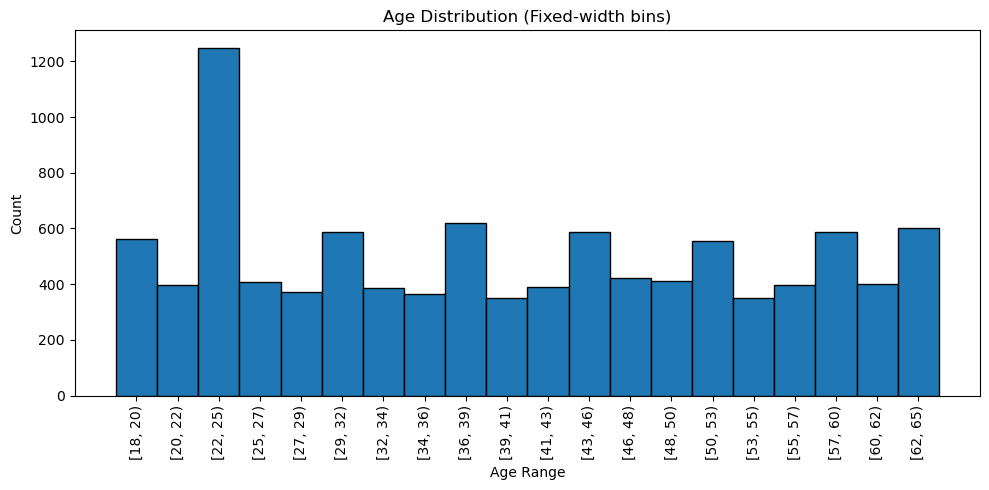

In [5]:
ages = df["age"].dropna()
n = len(ages)

# Freedman–Diaconis bin width
iqr = np.percentile(ages, 75) - np.percentile(ages, 25)
bin_width = 2 * iqr / (n ** (1/3))
n_bins = int(np.ceil((ages.max() - ages.min()) / bin_width))

print(f"FD suggested bin width: {bin_width:.2f}, number of bins: {n_bins}")


bins = np.linspace(ages.min(), ages.max(), n_bins + 1)
df["age_band_fd"] = pd.cut(df["age"], bins=bins)


age_summary = df.groupby("age_band_fd").agg(
    count=("id", "count"),
    min_age=("age", "min"),
    max_age=("age", "max")
).reset_index()

print("Statistically-derived Age Bands (Freedman–Diaconis)")
age_summary

plt.figure(figsize=(10,5))
counts, edges, patches = plt.hist(ages, bins=bins, edgecolor="k")

# Format x-axis labels as intervals
labels = [f"[{int(edges[i])}, {int(edges[i+1])})" for i in range(len(edges)-1)]
plt.xticks([(edges[i] + edges[i+1]) / 2 for i in range(len(edges)-1)], labels, rotation=90)

# Title and axes
plt.title("Age Distribution (Fixed-width bins)")
plt.xlabel("Age Range")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Using the Freedman–Diaconis method, we created age bands. Most bands have 400–600 applicants, showing a balanced spread, but the 22–25 group stands out with ~1,250 applications, meaning early 20s customers apply far more often than other groups. This spike highlights a key segment that should be tested further for approval and end-to-end conversion before deciding marketing investment.

Below code finishes preparing the dataset by creating clear, business-friendly groupings:

- **Age bands**: Ages are bucketed into neat 10-year ranges (e.g., 28–37, 38–47), ensuring no overlaps or mislabels.

- **Deposit ratio bands**: Customers are grouped by how much deposit they put down relative to the loan (<10%, 10–20%, etc.), which is a strong proxy for affordability.

- **LTV bands**: Loan-to-Value is split into standard risk brackets (≤70%, 70–80%, 80–90%, 90–100%), directly relevant for credit risk and pricing.

- Categorical interval columns are converted to strings so the dataset is SQL-ready.

In [6]:
def make_age_bands_clean(df, col="age", width=10):
    # integer min/max; add +1 so the max age is covered in the final right-open bin
    min_age = int(np.floor(df[col].min()))
    max_age = int(np.ceil(df[col].max()))
    bins    = np.arange(min_age, max_age + width + 1, width)  # e.g., 18,28,38,...

    # labels like 28–37, 38–47, ...
    labels  = [f"{int(bins[i])}–{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

    df["age_band"] = pd.cut(
        df[col],
        bins=bins,
        right=False,              # <-- left-closed, right-open: [28,38)
        labels=labels,
        include_lowest=True
    )
    return df

df = make_age_bands_clean(df, col="age", width=10)

df.reset_index(inplace = True,drop = True)

for col in df.select_dtypes(include="category").columns:
    if isinstance(df[col].dtype.categories[0], pd.Interval):
        df[col] = df[col].astype(str)
        

# --- Deposit Ratio Bands ---
bins = [0, 0.1, 0.2, 0.3, 0.5, 1.0]
labels = ["<10%", "10–20%", "20–30%", "30–50%", "50%+"]

df["deposit_ratio_band"] = pd.cut(
    df["deposit_ratio"], bins=bins, labels=labels, include_lowest=True
)

# --- LTV Bands ---
ltv_bins = [0, 0.7, 0.8, 0.9, 1.0]
ltv_labels = ["≤70%", "70–80%", "80–90%", "90–100%"]

df["ltv_band"] = pd.cut(
    df["ltv"], bins=ltv_bins, labels=ltv_labels, include_lowest=True
)


print("Final Cleaned Dataset")
df.drop(columns=['age_band_fd'],inplace = True)
df.head()

Final Cleaned Dataset


,id,age,car_type,loan_amount,deposit,area,apr,application_outcome,funded,deposit_ratio,ltv,age_band,deposit_ratio_band,ltv_band
0,1,48,Saloon,9636.0,1949.0,Urban,0.20,Approved,No,0.20,0.80,48–57,10–20%,70–80%
1,2,53,Suv,3402.0,1143.0,Rural,NaN,Declined,NaN,0.34,0.66,48–57,30–50%,≤70%
2,3,27,Suv,12431.0,2782.0,Urban,0.05,Approved,Yes,0.22,0.78,18–27,20–30%,70–80%
3,4,65,Convertible,13299.0,4679.0,Rural,0.25,Approved,No,0.35,0.65,58–67,30–50%,≤70%
4,5,38,Saloon,3409.0,1337.0,Urban,NaN,Declined,NaN,0.39,0.61,38–47,30–50%,≤70%


This final cleaned dataset is now in a structured, business-friendly format:

- Each applicant has core demographics (age, car type, area).
- Loan details are ready for analysis: loan amount, deposit, APR, deposit ratio, and LTV.
- Outcome flags show whether the application was approved and whether it funded.
- New categorical groupings make the data easy to slice:
- Age bands (18–27, 38–47, etc.)
- Deposit ratio bands (<10%, 10–20%, 30–50%, etc.)
- LTV bands (≤70%, 70–80%, etc.)
- APR and Funded values are NaN for declined applications, because APR is only assigned after approval, and only approved loans can proceed to funding.

### Missing Values Check

In [7]:
print("Missing values per column (%):")
print((df.isnull().mean() * 100.0).round(2))
print()
df.info()

Missing values per column (%):
id                      0.0
age                     0.0
car_type                0.0
loan_amount             0.0
deposit                 0.0
area                    0.0
apr                    35.3
application_outcome     0.0
funded                 35.3
deposit_ratio           0.0
ltv                     0.0
age_band                0.0
deposit_ratio_band      0.0
ltv_band                0.0
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   10000 non-null  int64   
 1   age                  10000 non-null  Int64   
 2   car_type             10000 non-null  object  
 3   loan_amount          10000 non-null  float64 
 4   deposit              10000 non-null  float64 
 5   area                 10000 non-null  object  
 6   apr                  6470 non-null   flo

The dataset contains 10,000 applications with 14 columns after cleaning and feature engineering.
There are no missing values in applicant demographics (age, car type, area) or loan details (loan amount, deposit, deposit ratio, LTV, and the derived bands).
APR and Funded each have about 35 percent missing values. This is expected and not a data quality issue. APR is only assigned after approval, so declined applications correctly show NaN. Funded status is also only relevant for approved applications, so declined ones show NaN.
The fact that there are exactly 6,470 non-null APR and Funded values matches the number of approved applications, which confirms consistency in the funnel logic.
Categorical groupings (age_band, deposit_ratio_band, ltv_band) are fully populated, meaning every application can be analyzed by demographic and affordability or risk segments.

### Bands for Loan Amount

In [8]:
# Define bins for Loan Amount (example: 5k intervals)
bins = range(0, int(df["loan_amount"].max()) + 5000, 5000)
labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins)-1)]

# Create a new column with loan amount ranges
df["loan_amount_range"] = pd.cut(df["loan_amount"], bins=bins, labels=labels, include_lowest=True)

# Filter approved rows
approved = df[df["application_outcome"].str.lower() == "approved"]

loan_range = approved[["id","loan_amount_range"]]
loan_range.head(10)

,id,loan_amount_range
0,1,5000–9999
2,3,10000–14999
3,4,10000–14999
5,6,10000–14999
6,7,5000–9999
7,8,15000–19999
8,9,10000–14999
9,10,20000–24999
10,11,20000–24999
11,12,10000–14999


The code creates loan amount bands in 5,000 intervals and assigns each approved application to its correct range. The sample output shows IDs mapped to bands such as 5,000–9,999, 10,000–14,999, 15,000–19,999, and 20,000–24,999. This confirms that the binning logic is working as intended and every approved loan is categorized into a clear and interpretable loan amount range that can now be used for funnel and conversion analysis.

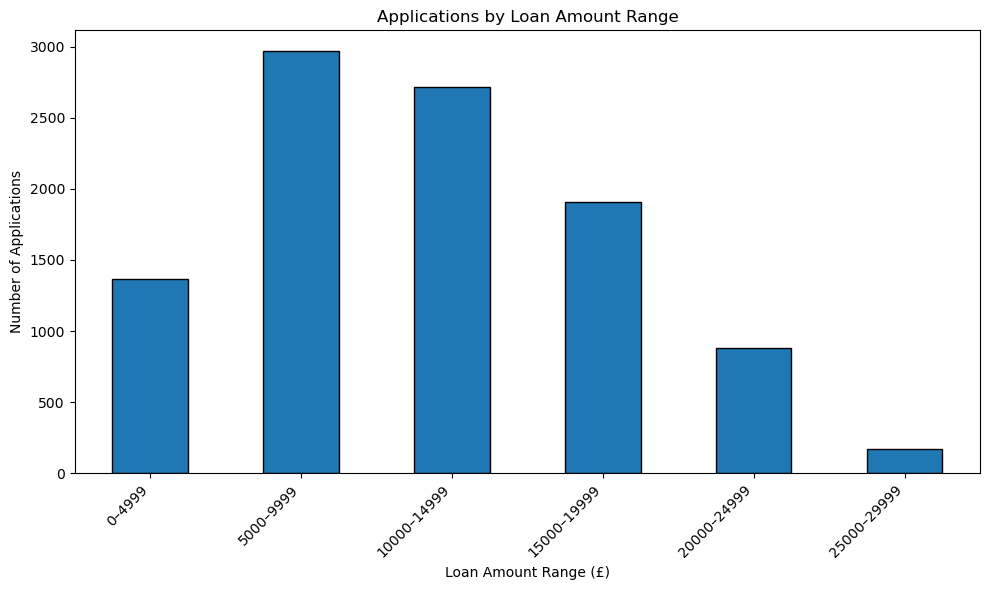

In [9]:
loan_counts = df["loan_amount_range"].value_counts().sort_index()
# Plot
plt.figure(figsize=(10,6))
loan_counts.plot(kind="bar", edgecolor="black")

# Labels and title
plt.title("Applications by Loan Amount Range")
plt.xlabel("Loan Amount Range (£)")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Load cleaned data into SQLite

The code connects to a SQLite database called fincar_test.db and writes the cleaned DataFrame df into a table named applications. If the table already exists, it gets replaced. A quick SQL check confirms the total number of rows, and then the first 10 records are retrieved to verify that the data has been correctly stored and structured in the database.

In [10]:
# Create SQLite connection (in-memory or file-based)
conn = sqlite3.connect("fincar_test.db")

# Write DataFrame to SQLite
df.to_sql("applications", conn, if_exists="replace", index=False)

# Quick check
print(pd.read_sql("SELECT COUNT(*) as n_rows FROM applications", conn))

pd.read_sql("SELECT * FROM applications LIMIT 10", conn)

   n_rows
0   10000


,id,age,car_type,loan_amount,deposit,area,apr,application_outcome,funded,deposit_ratio,ltv,age_band,deposit_ratio_band,ltv_band,loan_amount_range
0,1,48,Saloon,9636.0,1949.0,Urban,0.20,Approved,No,0.20,0.80,48–57,10–20%,70–80%,5000–9999
1,2,53,Suv,3402.0,1143.0,Rural,NaN,Declined,None,0.34,0.66,48–57,30–50%,≤70%,0–4999
2,3,27,Suv,12431.0,2782.0,Urban,0.05,Approved,Yes,0.22,0.78,18–27,20–30%,70–80%,10000–14999
3,4,65,Convertible,13299.0,4679.0,Rural,0.25,Approved,No,0.35,0.65,58–67,30–50%,≤70%,10000–14999
4,5,38,Saloon,3409.0,1337.0,Urban,NaN,Declined,None,0.39,0.61,38–47,30–50%,≤70%,0–4999
5,6,60,Suv,14056.0,2420.0,Urban,0.10,Approved,No,0.17,0.83,58–67,10–20%,80–90%,10000–14999
6,7,46,Suv,5012.0,3097.0,Urban,0.05,Approved,No,0.62,0.38,38–47,50%+,≤70%,5000–9999
7,8,51,Convertible,15881.0,742.0,Urban,0.05,Approved,No,0.05,0.95,48–57,<10%,90–100%,15000–19999
8,9,60,Convertible,13039.0,3683.0,Rural,0.20,Approved,Yes,0.28,0.72,58–67,20–30%,70–80%,10000–14999
9,10,34,Convertible,22713.0,4153.0,Rural,0.05,Approved,Yes,0.18,0.82,28–37,10–20%,80–90%,20000–24999


The quick check shows that the table has 10,000 rows, matching the DataFrame size. The sample records confirm that all columns have been preserved, including engineered features such as deposit_ratio, ltv, and the banded variables (age_band, deposit_ratio_band, ltv_band, loan_amount_range). Declined applications correctly have NaN values for apr and funded, while approved applications show valid values. This confirms the data was successfully loaded into SQLite and is ready for SQL-based analysis.

The below code connects to the existing SQLite database and saves the loan_range DataFrame into a new table named loan_range. If the table already exists, it gets replaced. Finally, the first 10 rows are queried to confirm that the table has been created and populated correctly.

In [11]:
# Reuse or create connection
conn = sqlite3.connect("fincar_test.db")

# Save to a new table
loan_range.to_sql("loan_range", conn, if_exists="replace", index=False)

pd.read_sql("SELECT * FROM loan_range LIMIT 10;", conn)


,id,loan_amount_range
0,1,5000–9999
1,3,10000–14999
2,4,10000–14999
3,6,10000–14999
4,7,5000–9999
5,8,15000–19999
6,9,10000–14999
7,10,20000–24999
8,11,20000–24999
9,12,10000–14999


The preview shows that the new table loan_range contains two columns: id and loan_amount_range. Each applicant ID is mapped to its respective loan band in 5,000 intervals (for example, 5,000–9,999, 10,000–14,999, 15,000–19,999). This confirms that the binning logic worked and the ranges were successfully stored in the database for further analysis.

## Downloading Updated dataset for Tableau Visualisation

In [12]:
## UNCOMMENT BELOW QUERY ONLY IF CLEANED FILE NEEDS TO BE DOWNLOADED IN LOCAL SYSTEM 

# query = """
# SELECT 
#     a.*,
#     l.loan_amount_range
# FROM applications a
# LEFT JOIN loan_range l ON a.id = l.id
# """
# cleaned_df = pd.read_sql(query, conn)

# # Export to CSV
# cleaned_df.to_csv("FinCar_Finance_cleaned_dataset.csv", index=False, encoding = 'utf-8-sig')

# print("Cleaned dataset saved as cleaned_dataset.csv")


## Analysis of the Data

### Approval and Funded Rate

The SQL query calculates key funnel metrics from the applications table. It counts the total number of applications, the number approved, and the number funded. It also computes the approval rate as approvals divided by applications, and the funded rate as funded divided by applications. The results are read back into Python using pd.read_sql.

In [13]:
sql = """
SELECT 
    COUNT(*) AS applications,
    SUM(CASE WHEN application_outcome= "Approved" THEN 1 ELSE 0 END) AS approvals,
    ROUND(AVG(CASE WHEN application_outcome= "Approved" THEN 1.0 ELSE 0 END),4)*100.0 AS approval_rate,
    SUM(CASE WHEN funded="Yes" THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN funded="Yes" THEN 1.0 ELSE 0 END),4)*100.0 AS funded_rate
FROM applications
"""
pd.read_sql(sql, conn)

,applications,approvals,approval_rate,funded,funded_rate
0,10000,6470,64.7,3069,30.69


Out of 10,000 applications, 6,470 were approved, giving an approval rate of 64.7 percent. Of these, 3,069 resulted in funded loans, giving an end-to-end funded rate of 30.7 percent. This establishes the overall funnel baseline: roughly two-thirds of applicants pass approval, and about one-third of all applicants ultimately fund. This baseline is the benchmark against which segment performance should be compared.

### Age distribution

The query groups all applications by age_band and calculates key funnel metrics for each age group. It counts total applications, approvals, and funded loans. It also computes approval percent, funded percent (funded divided by total applications), and explicit drop-off percentages between application to approval and approval to funded. The results are then read into Python for further analysis.

The query groups applications by age_band and calculates funnel metrics for each age band. It reports total applications, approvals, and funded loans, along with three key rates: approval rate (approvals per applications), conversion post approval (funded per approvals), and funded per application (funded per applications). This provides a full view of funnel efficiency by age group.

In [14]:
query = """
SELECT 
    age_band,
    COUNT(*) AS total_applications,
    SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
    ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
    SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent,
    ROUND(100.0*(COUNT(*) - SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END))/COUNT(*),2) AS drop_app_to_approval_pct,
    ROUND(100.0*(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END) - SUM(CASE WHEN funded='Yes' THEN 1 ELSE 0 END))/
            NULLIF(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END),0),2) AS drop_approval_to_funded_pct,
    ROUND(SUM(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END)*100.0 / NULLIF(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END),0),2) AS conversion_post_approval,
    ROUND(SUM(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END)*100.0 / COUNT(*),2) AS funded_per_app
FROM applications
GROUP BY age_band
ORDER BY age_band;
"""
age_dist = pd.read_sql(query, conn)
age_dist


,age_band,total_applications,approved,approved_percent,funded,funded_percent,drop_app_to_approval_pct,drop_approval_to_funded_pct,conversion_post_approval,funded_per_app
0,18–27,2618,789,30.14,367,14.02,69.86,53.49,46.51,14.02
1,28–37,1905,1040,54.59,501,26.30,45.41,51.83,48.17,26.30
2,38–47,1972,1610,81.64,758,38.44,18.36,52.92,47.08,38.44
3,48–57,1917,1601,83.52,730,38.08,16.48,54.40,45.60,38.08
4,58–67,1588,1430,90.05,713,44.90,9.95,50.14,49.86,44.90


The table shows clear age-based differences in funnel performance. Younger applicants aged 18–27 submit the most applications but have the weakest funnel, with only 30.1 percent approved and an overall funded rate of 14.0 percent, reflecting high drop-offs at the first stage. By contrast, older groups perform much better. Applicants aged 58–67 achieve the strongest results with a 90.1 percent approval rate and 44.9 percent overall funded rate, and minimal drop-off at the application stage. Middle-aged groups (38–57) also perform well with approvals above 80 percent and funded rates near 38 percent. This highlights that older applicants are consistently higher quality leads, while younger applicants represent high volume but low efficiency for marketing investment. This is visually presented below for better understanding.

The youngest group 18–27 generates the most applications (2,618) but performs poorly with only a 30.1% approval rate and a very weak 14.0% funded per application. In contrast, older groups show much stronger quality. Applicants aged 58–67 achieve the highest 90.1% approval rate and the best 44.9% funded per application, followed closely by the 38–47 and 48–57 groups, both with funded rates above 38%. Middle-aged applicants 28–37 sit between the extremes with a 26.3% funded rate. For marketing, this makes it clear that older applicants, particularly those over 38, are high-quality leads worth prioritizing, while younger applicants drive volume but yield low returns.

Younger applicants show the heaviest losses early in the funnel. In the 18–27 band, nearly 70% drop out at the application-to-approval stage, and a further 53% drop off post-approval, leaving very few funded. Older groups perform much better. Applicants aged 38–57 lose less than 20% before approval, though about half still drop off after approval. The 58–67 band is strongest with only a 10% drop before approval and about 50% after approval, making them the most reliable segment. For marketing, this shows that younger leads generate volume but are highly inefficient, while older applicants, especially 58–67, provide far better quality with minimal early-stage leakage.

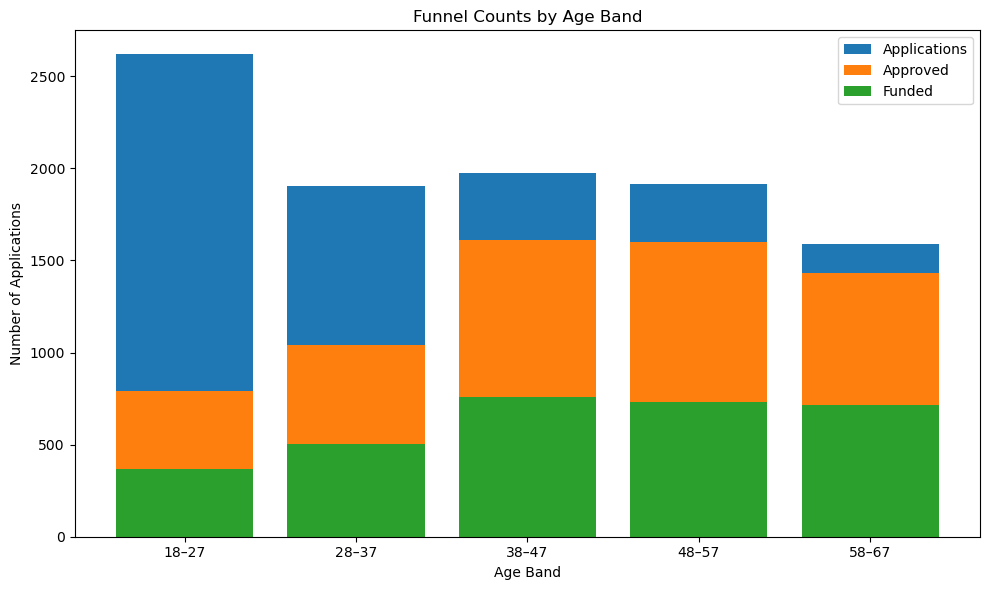

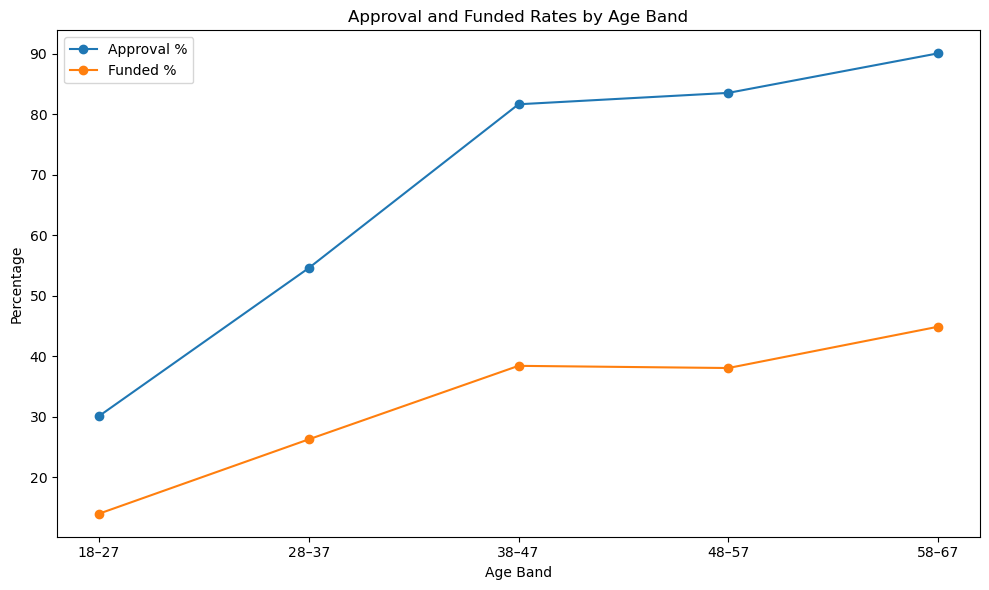

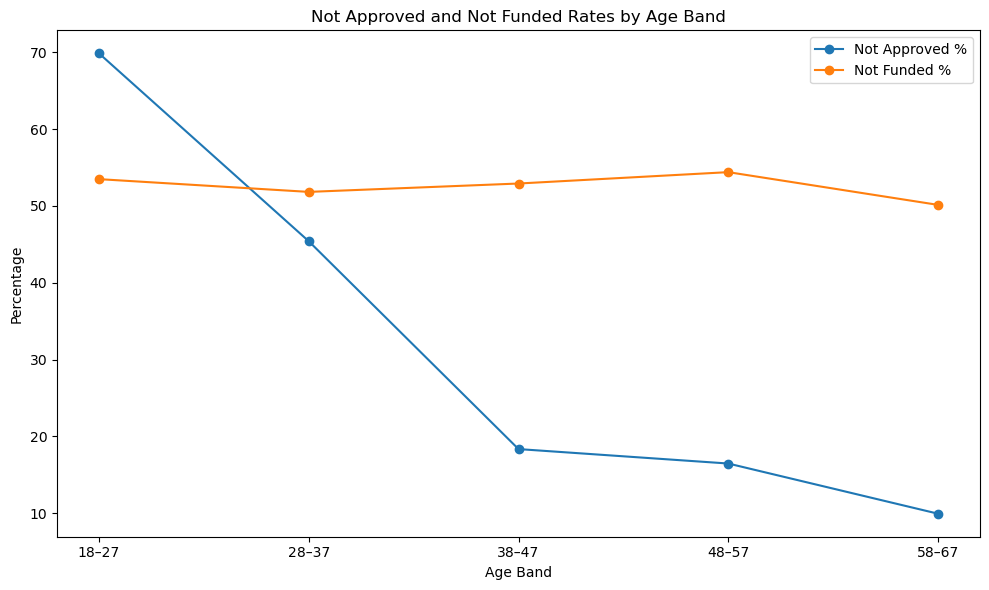

In [15]:
# Bar chart for counts (Applications, Approvals, Funded)
plt.figure(figsize=(10,6))
plt.bar(age_dist["age_band"], age_dist["total_applications"], label="Applications")
plt.bar(age_dist["age_band"], age_dist["approved"], label="Approved")
plt.bar(age_dist["age_band"], age_dist["funded"], label="Funded")
plt.title("Funnel Counts by Age Band")
plt.xlabel("Age Band")
plt.ylabel("Number of Applications")
plt.legend()
plt.tight_layout()
plt.show()

# Line chart for rates (Approval %, Funded %)
plt.figure(figsize=(10,6))
plt.plot(age_dist["age_band"], age_dist["approved_percent"], marker="o", label="Approval %")
plt.plot(age_dist["age_band"], age_dist["funded_percent"], marker="o", label="Funded %")
plt.title("Approval and Funded Rates by Age Band")
plt.xlabel("Age Band")
plt.ylabel("Percentage")
plt.legend()
plt.tight_layout()
plt.show()


# Drop-off rates chart (where funnel leaks)
plt.figure(figsize=(10,6))
plt.plot(age_dist["age_band"], age_dist["drop_app_to_approval_pct"], marker="o", label="Not Approved %")
plt.plot(age_dist["age_band"], age_dist["drop_approval_to_funded_pct"], marker="o", label="Not Funded %")
plt.title("Not Approved and Not Funded Rates by Age Band")
plt.xlabel("Age Band")
plt.ylabel("Percentage")
plt.legend()
plt.tight_layout()
plt.show()


### Car type distribution

The query groups applications by car_type and calculates funnel metrics for each group. It reports total applications, approvals, and funded loans, along with approval percent, funded percent, and explicit drop-off percentages from application to approval and from approval to funding. The results are ordered by the number of applications to show the largest segments first.

The query groups applications by car_type and calculates funnel metrics at each stage. It counts applications, approvals, and funded loans. It then computes three rates: approval rate (approvals per applications), conversion post approval (funded per approvals), and end-to-end funded per application (funded per applications). This gives a complete funnel view by vehicle type.

In [16]:
query = """
SELECT 
    car_type,
    COUNT(*) AS total_applications,
    SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
    ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
    SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent,
    ROUND(100.0*(COUNT(*) - SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END))/COUNT(*),2) AS drop_app_to_approval_pct,
    ROUND(100.0*(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END) - SUM(CASE WHEN funded='Yes' THEN 1 ELSE 0 END))/
            NULLIF(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END),0),2) AS drop_approval_to_funded_pct,
    ROUND(SUM(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END)*100.0 / NULLIF(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END),0),2) AS conversion_post_approval,
    ROUND(SUM(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END)*100.0 / COUNT(*),2) AS funded_per_app
FROM applications
GROUP BY car_type
ORDER BY total_applications DESC;
"""
car_type_dist = pd.read_sql(query, conn)
car_type_dist


,car_type,total_applications,approved,approved_percent,funded,funded_percent,drop_app_to_approval_pct,drop_approval_to_funded_pct,conversion_post_approval,funded_per_app
0,Suv,3830,2226,58.12,1054,27.52,41.88,52.65,47.35,27.52
1,Saloon,3137,2127,67.80,984,31.37,32.20,53.74,46.26,31.37
2,Convertible,3033,2117,69.80,1031,33.99,30.20,51.30,48.70,33.99


SUVs generate the most applications (3,830) but have the lowest efficiency, with an approval rate of 58.1 percent and an end-to-end funded rate of 27.5 percent. Saloons perform better with a 67.8 percent approval rate and 31.4 percent funded rate, while Convertibles lead slightly with the highest approval rate at 69.8 percent and the strongest funded rate at 34.0 percent. Drop-off patterns show that Convertibles and Saloons are consistently higher quality leads compared to SUVs, making them more attractive for marketing investment despite SUVs delivering the largest raw volume.

SUVs generate the most applications at 3,830 but are the weakest segment with only a 58.1% approval rate and a 27.5% end-to-end funded rate. Saloons improve with a 67.8% approval rate and a 31.4% funded rate, while Convertibles perform best, achieving both the highest approval rate of 69.8% and the strongest funded rate of 34.0%. Post-approval conversion is relatively stable across types, around 46–49%. For marketing, this means that although SUVs deliver high volume, they are inefficient, while Convertibles and Saloons produce higher quality leads. Investment should therefore prioritize Convertibles first and Saloons second, with less emphasis on SUVs despite their size.

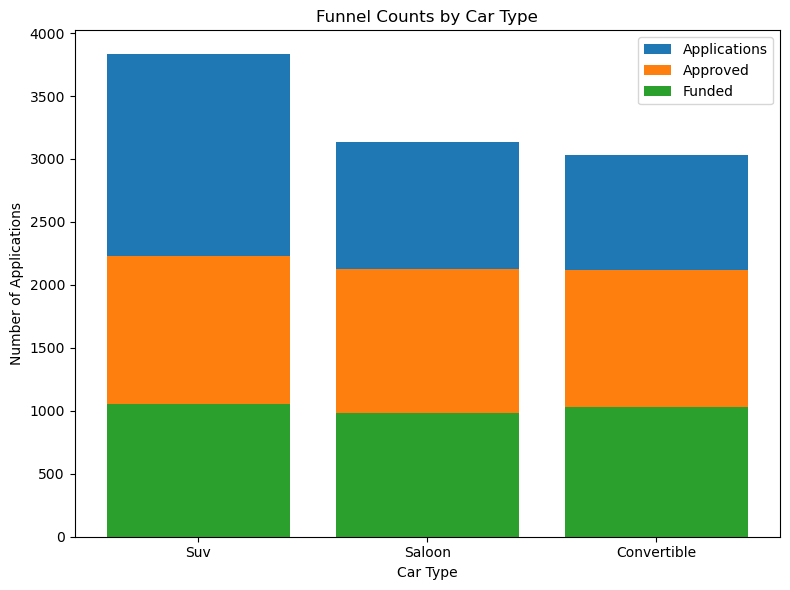

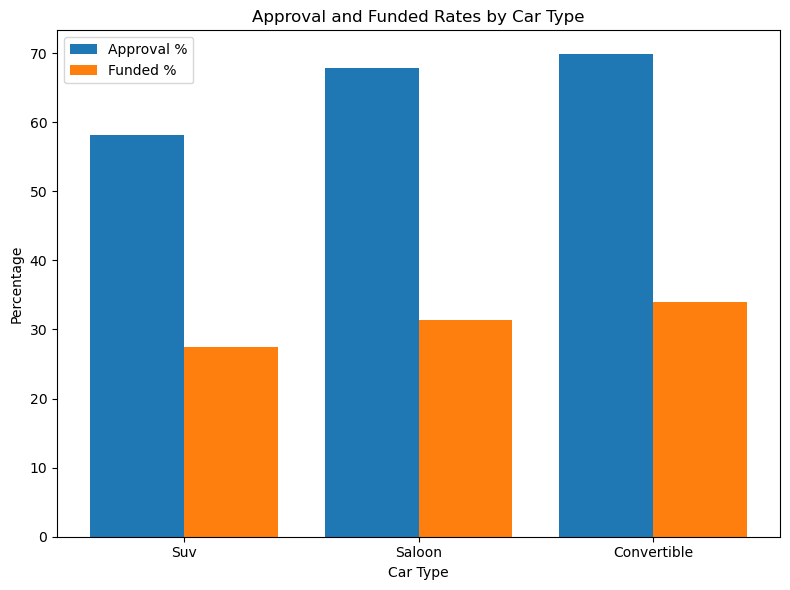

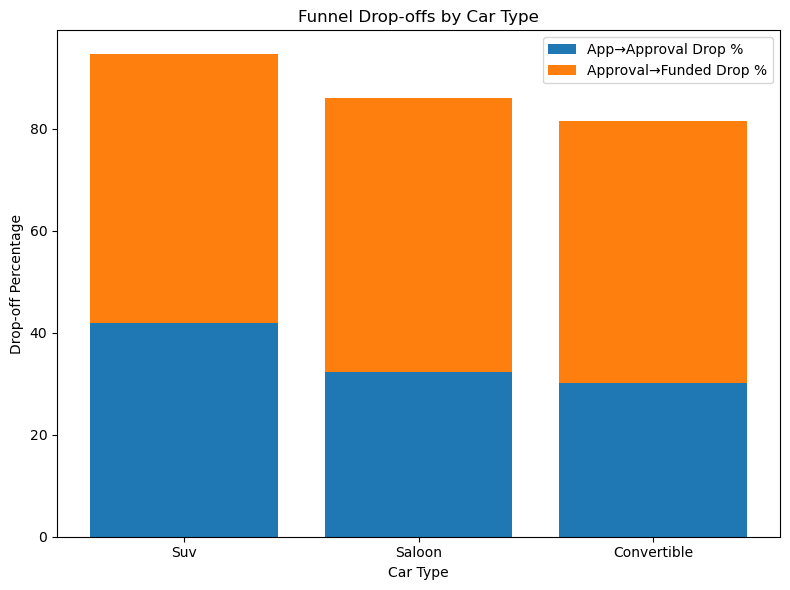

In [17]:
# Bar chart for counts (Applications, Approvals, Funded)
plt.figure(figsize=(8,6))
plt.bar(car_type_dist["car_type"], car_type_dist["total_applications"], label="Applications")
plt.bar(car_type_dist["car_type"], car_type_dist["approved"], label="Approved")
plt.bar(car_type_dist["car_type"], car_type_dist["funded"], label="Funded")
plt.title("Funnel Counts by Car Type")
plt.xlabel("Car Type")
plt.ylabel("Number of Applications")
plt.legend()
plt.tight_layout()
plt.show()

# Grouped bar chart for rates (Approval %, Funded %)
x = range(len(car_type_dist))
plt.figure(figsize=(8,6))
plt.bar([i-0.2 for i in x], car_type_dist["approved_percent"], width=0.4, label="Approval %")
plt.bar([i+0.2 for i in x], car_type_dist["funded_percent"], width=0.4, label="Funded %")
plt.xticks(x, car_type_dist["car_type"])
plt.title("Approval and Funded Rates by Car Type")
plt.xlabel("Car Type")
plt.ylabel("Percentage")
plt.legend()
plt.tight_layout()
plt.show()

# Drop-off rates chart (where funnel leaks)
plt.figure(figsize=(8,6))
plt.bar(car_type_dist["car_type"], car_type_dist["drop_app_to_approval_pct"], label="App→Approval Drop %")
plt.bar(car_type_dist["car_type"], car_type_dist["drop_approval_to_funded_pct"], bottom=car_type_dist["drop_app_to_approval_pct"], label="Approval→Funded Drop %")
plt.title("Funnel Drop-offs by Car Type")
plt.xlabel("Car Type")
plt.ylabel("Drop-off Percentage")
plt.legend()
plt.tight_layout()
plt.show()


### Area distribution

The query groups applications by area (Urban vs Rural) and calculates funnel metrics. It counts total applications, approvals, and funded loans, and computes approval percent, funded percent, and the drop-off percentages between application to approval and approval to funding. Results are ordered by the number of applications.

The query groups applications by area (Rural vs Urban) and calculates funnel performance. It reports applications, approvals, and funded loans, along with approval rate (approvals per applications), conversion post approval (funded per approvals), and funded per application (funded per applications). This enables a direct comparison of funnel efficiency between Rural and Urban customers.

In [18]:
query = """
SELECT 
    area,
    COUNT(*) AS total_applications,
    SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
    ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
    SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent,
    ROUND(100.0*(COUNT(*) - SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END))/COUNT(*),2) AS drop_app_to_approval_pct,
    ROUND(100.0*(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END) - SUM(CASE WHEN funded='Yes' THEN 1 ELSE 0 END))/
    NULLIF(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END),0),2) AS drop_approval_to_funded_pct,
    ROUND(SUM(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END)*100.0 / NULLIF(SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END),0),2) AS conversion_post_approval,
    ROUND(SUM(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END)*100.0 / COUNT(*),2) AS funded_per_app
    FROM applications
GROUP BY area
ORDER BY total_applications DESC;
"""
area_dist = pd.read_sql(query, conn)
area_dist.head()

,area,total_applications,approved,approved_percent,funded,funded_percent,drop_app_to_approval_pct,drop_approval_to_funded_pct,conversion_post_approval,funded_per_app
0,Rural,5290,3043,57.52,1245,23.53,42.48,59.09,40.91,23.53
1,Urban,4710,3427,72.76,1824,38.73,27.24,46.78,53.22,38.73


Rural applicants make up the majority with 5,290 applications, but they perform poorly with only a 57.5 percent approval rate and a low 23.5 percent funded rate. Urban applicants have fewer applications (4,710) but deliver much stronger quality, with a 72.8 percent approval rate and a 38.7 percent funded rate. Drop-off analysis shows Rural leads suffer both at approval and post-approval stages, while Urban leads are significantly more efficient. For marketing, this suggests that focusing spend on Urban applicants yields a much higher return than Rural despite smaller raw volume.

Rural areas generate more applications (5,290) but with weaker performance: only a 57.5% approval rate, a 40.9% post-approval conversion, and an overall 23.5% funded rate per application. Urban areas, despite fewer applications (4,710), perform much better with a 72.8% approval rate, a 53.2% post-approval conversion, and a strong 38.7% funded rate per application. For marketing, this indicates that Urban applicants deliver far higher ROI, making them a more effective target for acquisition spend, while Rural leads provide volume but with lower quality and efficiency.

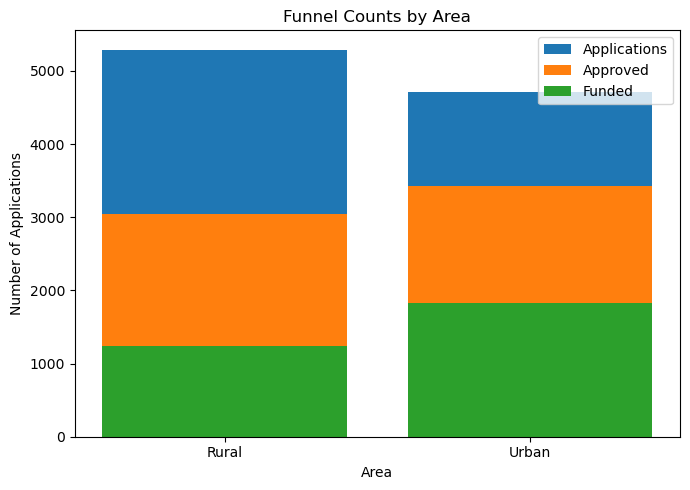

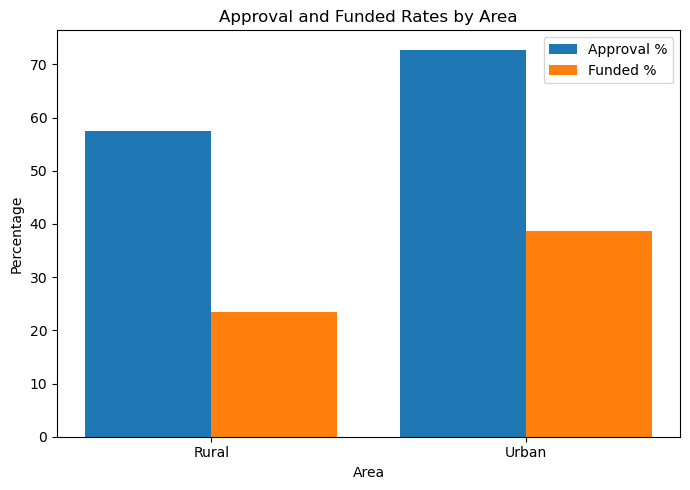

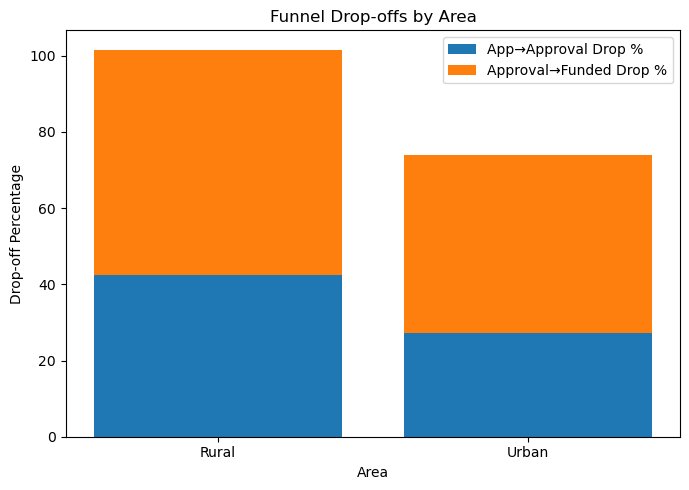

In [19]:
import matplotlib.pyplot as plt

# Bar chart for counts (Applications, Approvals, Funded)
plt.figure(figsize=(7,5))
plt.bar(area_dist["area"], area_dist["total_applications"], label="Applications")
plt.bar(area_dist["area"], area_dist["approved"], label="Approved")
plt.bar(area_dist["area"], area_dist["funded"], label="Funded")
plt.title("Funnel Counts by Area")
plt.xlabel("Area")
plt.ylabel("Number of Applications")
plt.legend()
plt.tight_layout()
plt.show()

# Grouped bar chart for rates (Approval %, Funded %)
x = range(len(area_dist))
plt.figure(figsize=(7,5))
plt.bar([i-0.2 for i in x], area_dist["approved_percent"], width=0.4, label="Approval %")
plt.bar([i+0.2 for i in x], area_dist["funded_percent"], width=0.4, label="Funded %")
plt.xticks(x, area_dist["area"])
plt.title("Approval and Funded Rates by Area")
plt.xlabel("Area")
plt.ylabel("Percentage")
plt.legend()
plt.tight_layout()
plt.show()

# Drop-off stacked bar chart
plt.figure(figsize=(7,5))
plt.bar(area_dist["area"], area_dist["drop_app_to_approval_pct"], label="App→Approval Drop %")
plt.bar(area_dist["area"], area_dist["drop_approval_to_funded_pct"],
        bottom=area_dist["drop_app_to_approval_pct"], label="Approval→Funded Drop %")
plt.title("Funnel Drop-offs by Area")
plt.xlabel("Area")
plt.ylabel("Drop-off Percentage")
plt.legend()
plt.tight_layout()
plt.show()


### Age vs Car type

The query first aggregates applications by both age_band and car_type, calculating total applications, approvals, funded loans, approval percent, and funded percent. A window function RANK() is then applied to rank car types within each age band by approval percent, so that for every age group the car types are ordered from highest to lowest approval rate.

In [20]:
query = """
WITH agg AS (
    SELECT 
        age_band,
        car_type,
        COUNT(*) AS total_applications,
        SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
        ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
        SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
        ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent
    FROM applications
    GROUP BY age_band, car_type
)
SELECT RANK() OVER (PARTITION BY age_band ORDER BY approved_percent DESC) AS rank_within_age, *
FROM agg
ORDER BY age_band, rank_within_age;
"""
age_car = pd.read_sql(query, conn)
age_car


,rank_within_age,age_band,car_type,total_applications,approved,approved_percent,funded,funded_percent
0,1,18–27,Convertible,599,239,39.90,121,20.20
1,2,18–27,Saloon,658,251,38.15,108,16.41
2,3,18–27,Suv,1361,299,21.97,138,10.14
3,1,28–37,Convertible,633,357,56.40,173,27.33
4,2,28–37,Suv,632,350,55.38,180,28.48
5,3,28–37,Saloon,640,333,52.03,148,23.13
6,1,38–47,Suv,641,529,82.53,251,39.16
7,2,38–47,Saloon,699,570,81.55,272,38.91
8,3,38–47,Convertible,632,511,80.85,235,37.18
9,1,48–57,Suv,653,550,84.23,241,36.91


The results show which car types perform best within each age group. For younger applicants aged 18–27, Convertibles lead with an approval rate of 39.9 percent, while SUVs lag at just 22.0 percent. In contrast, older groups show consistently high approval rates across all car types. For example, applicants aged 58–67 achieve approval rates above 89 percent for every car type, with SUVs slightly ahead at 91.7 percent. Funded percentages follow a similar pattern, with the highest end-to-end performance observed in older age bands regardless of car type. This highlights that while young applicants are risky across all cars, older applicants represent strong leads across all car categories.

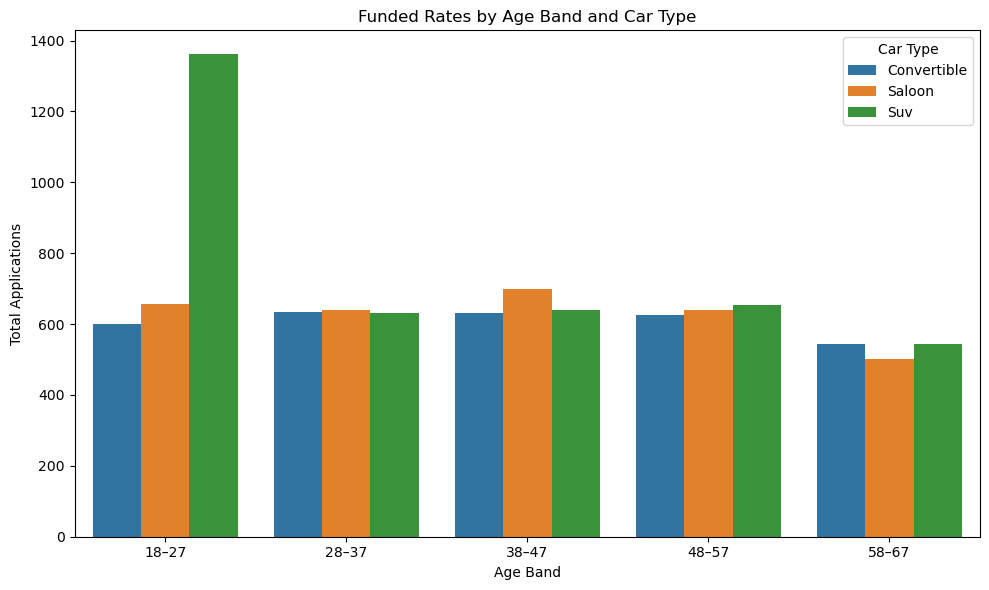

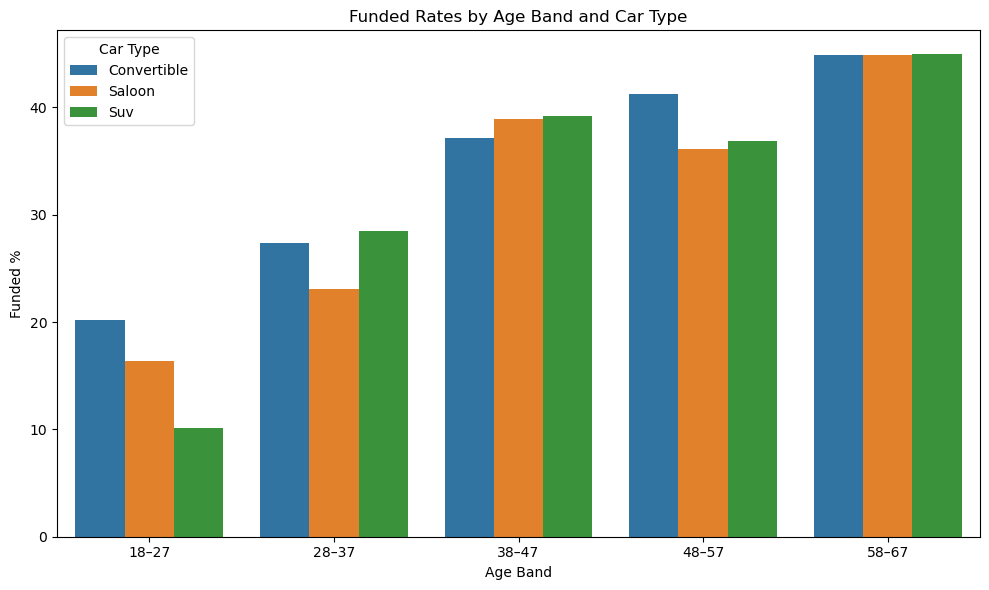

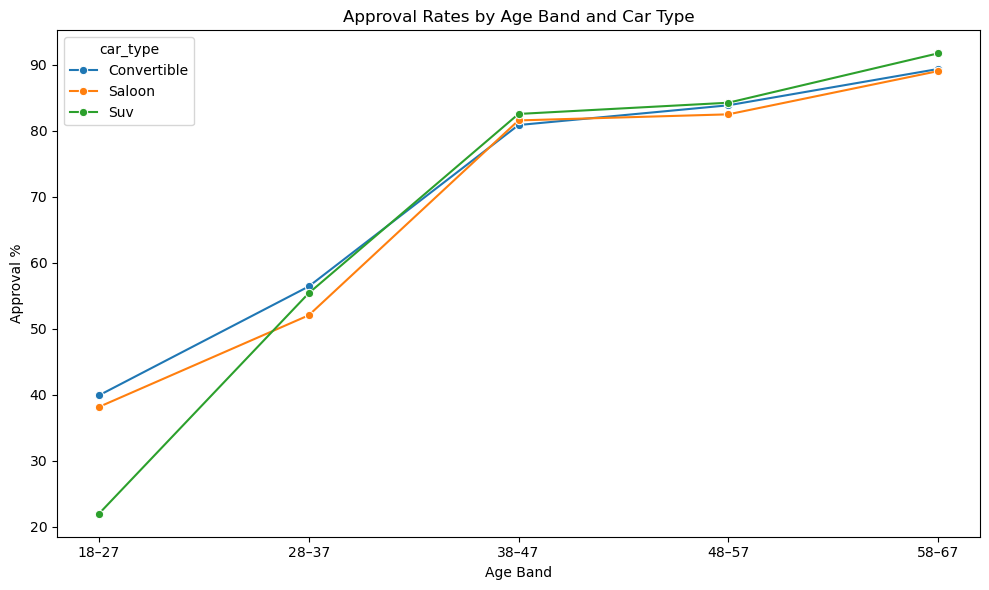

In [21]:
# Create a grouped bar chart for total application by car type within each age band
plt.figure(figsize=(10,6))
sns.barplot(data=age_car, x="age_band", y="total_applications", hue="car_type")

plt.title("Funded Rates by Age Band and Car Type")
plt.xlabel("Age Band")
plt.ylabel("Total Applications")
plt.legend(title="Car Type")
plt.tight_layout()
plt.show()


# Create a grouped bar chart for funded percent by car type within each age band
plt.figure(figsize=(10,6))
sns.barplot(data=age_car, x="age_band", y="funded_percent", hue="car_type")

plt.title("Funded Rates by Age Band and Car Type")
plt.xlabel("Age Band")
plt.ylabel("Funded %")
plt.legend(title="Car Type")
plt.tight_layout()
plt.show()

# Optional: line plot for approval % trends
plt.figure(figsize=(10,6))
sns.lineplot(data=age_car, x="age_band", y="approved_percent", hue="car_type", marker="o")
plt.title("Approval Rates by Age Band and Car Type")
plt.xlabel("Age Band")
plt.ylabel("Approval %")
plt.tight_layout()
plt.show()


### Age vs Area

The query aggregates applications by both age_band and area, computing totals, approvals, funded loans, and the corresponding approval and funded percentages. It then uses a RANK() window function to rank areas within each age band by approval percent, so for every age group Urban and Rural applicants can be directly compared.

In [22]:
query = """
WITH agg AS (
    SELECT 
        age_band,
        area,
        COUNT(*) AS total_applications,
        SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
        ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
        SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
        ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent
    FROM applications
    GROUP BY age_band, area
)
SELECT RANK() OVER (PARTITION BY age_band ORDER BY approved_percent DESC) AS rank_within_area, *
FROM agg
ORDER BY age_band, rank_within_area;
"""
age_area = pd.read_sql(query, conn)
age_area


,rank_within_area,age_band,area,total_applications,approved,approved_percent,funded,funded_percent
0,1,18–27,Urban,1009,435,43.11,226,22.40
1,2,18–27,Rural,1609,354,22.00,141,8.76
2,1,28–37,Urban,934,538,57.60,290,31.05
3,2,28–37,Rural,971,502,51.70,211,21.73
4,1,38–47,Urban,1012,863,85.28,462,45.65
5,2,38–47,Rural,960,747,77.81,296,30.83
6,1,48–57,Urban,950,822,86.53,423,44.53
7,2,48–57,Rural,967,779,80.56,307,31.75
8,1,58–67,Urban,805,769,95.53,423,52.55
9,2,58–67,Rural,783,661,84.42,290,37.04


Across all age groups, Urban applicants consistently outperform Rural applicants. For ages 18–27, Urban has a 43.1 percent approval rate versus 22.0 percent in Rural, with funded rates of 22.4 percent and 8.8 percent respectively. This pattern strengthens with age. By 58–67, Urban applicants achieve a 95.5 percent approval rate and a 52.6 percent funded rate, compared to 84.4 percent approval and 37.0 percent funded in Rural. The ranking confirms that Urban consistently leads within every age band, making Urban applicants significantly higher quality leads for marketing investment.

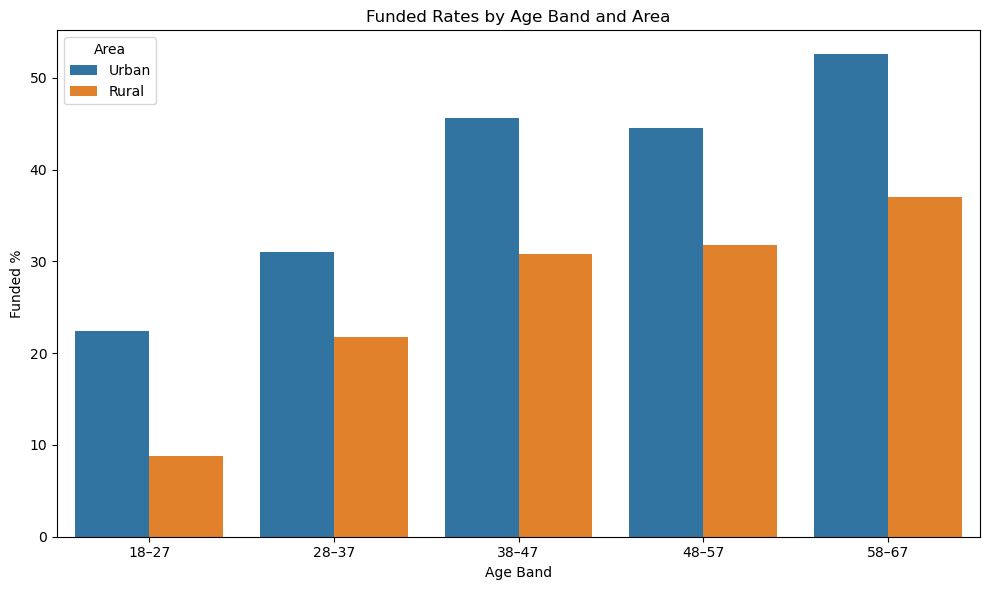

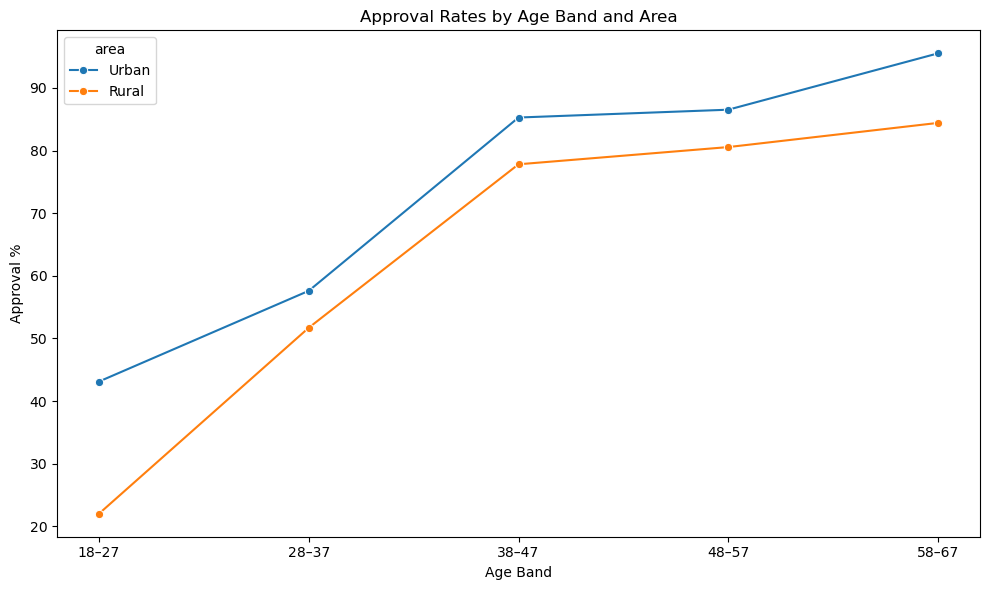

In [23]:
# Grouped bar chart: Funded % by Age Band & Area
plt.figure(figsize=(10,6))
sns.barplot(data=age_area, x="age_band", y="funded_percent", hue="area")

plt.title("Funded Rates by Age Band and Area")
plt.xlabel("Age Band")
plt.ylabel("Funded %")
plt.legend(title="Area")
plt.tight_layout()
plt.show()

# Line plot: Approval % trend by Age Band & Area
plt.figure(figsize=(10,6))
sns.lineplot(data=age_area, x="age_band", y="approved_percent", hue="area", marker="o")

plt.title("Approval Rates by Age Band and Area")
plt.xlabel("Age Band")
plt.ylabel("Approval %")
plt.tight_layout()
plt.show()


### Age vs Car vs Area

The query aggregates applications by a three-way combination of age_band, car_type, and area. For each segment it calculates total applications, approvals, approval percent, funded loans, funded percent, and the average funded loan amount. A window function RANK() is then used to rank car types within each age group by approval percent, allowing direct comparison of Urban and Rural results across car types and ages.

In [24]:
query = """
WITH agg AS (
    SELECT 
        age_band,
        car_type,
        area,
        COUNT(*) AS total_applications,
        SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
        ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
        SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
        ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent,
        ROUND(AVG(CASE WHEN funded = 'Yes' THEN loan_amount END), 2) AS avg_funded_loan_amount
    FROM applications
    GROUP BY age_band,car_type, area
)
SELECT RANK() OVER (PARTITION BY age_band ORDER BY approved_percent DESC) AS rank_within_car_area, *
FROM agg
ORDER BY age_band, rank_within_car_area;
"""
age_car_area = pd.read_sql(query, conn)
age_car_area


,rank_within_car_area,age_band,car_type,area,total_applications,approved,approved_percent,funded,funded_percent,avg_funded_loan_amount
0,1,18–27,Suv,Urban,369,175,47.43,91,24.66,11845.26
1,2,18–27,Saloon,Urban,339,138,40.71,63,18.58,9212.62
2,3,18–27,Convertible,Urban,301,122,40.53,72,23.92,16880.72
3,4,18–27,Convertible,Rural,298,117,39.26,49,16.44,15831.51
4,5,18–27,Saloon,Rural,319,113,35.42,45,14.11,7962.67
5,6,18–27,Suv,Rural,992,124,12.50,47,4.74,12023.19
6,1,28–37,Suv,Urban,316,188,59.49,107,33.86,10823.41
7,2,28–37,Convertible,Urban,315,186,59.05,94,29.84,16794.22
8,3,28–37,Saloon,Urban,303,164,54.13,89,29.37,8695.90
9,4,28–37,Convertible,Rural,318,171,53.77,79,24.84,16816.76


The results reveal which specific age–car–area personas perform best. Among 18–27 year olds, Urban SUVs have the strongest approval rate (47.4 percent) but still underperform older groups, while Rural SUVs lag heavily at only 12.5 percent approval and 4.7 percent funded. By 38–47, all Urban car types achieve approvals above 84 percent with funded rates near 45 percent, showing strong quality leads. The top performers overall are older Urban applicants, especially 58–67 Convertibles and SUVs, with approval rates above 95 percent and funded rates over 50 percent. Average funded loan amounts also show that Convertibles consistently carry higher loan sizes compared to Saloons and SUVs. This output highlights that the most valuable marketing targets are older Urban applicants across all car types, especially Convertibles, while younger Rural SUV applicants are the least efficient to acquire.

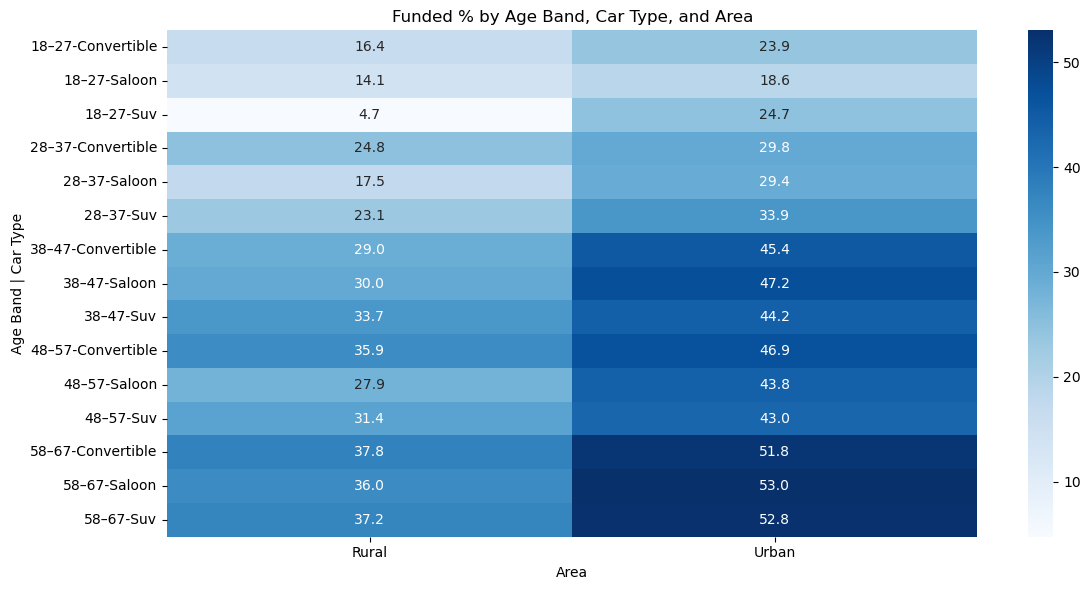

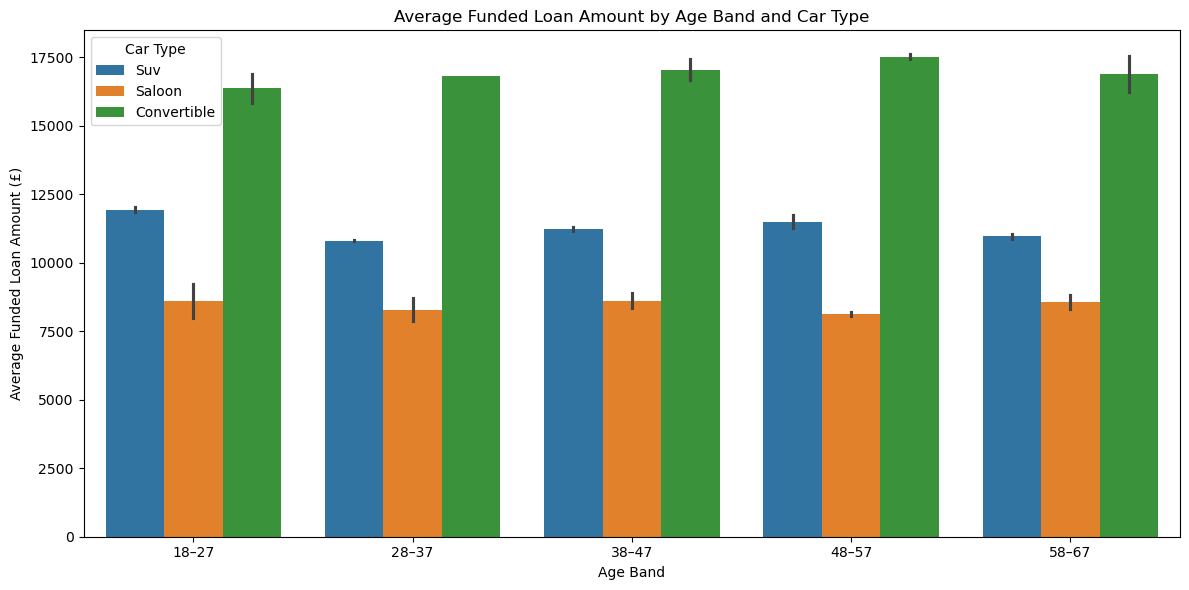

In [25]:
# Funded % heatmap by Age Band & Car Type, split by Area
plt.figure(figsize=(12,6))
pivot_data = age_car_area.pivot_table(
    index=["age_band","car_type"], columns="area", values="funded_percent"
)

sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap="Blues")
plt.title("Funded % by Age Band, Car Type, and Area")
plt.xlabel("Area")
plt.ylabel("Age Band | Car Type")
plt.tight_layout()
plt.show()

# Average funded loan amount grouped bar
plt.figure(figsize=(12,6))
sns.barplot(data=age_car_area, x="age_band", y="avg_funded_loan_amount", hue="car_type")
plt.title("Average Funded Loan Amount by Age Band and Car Type")
plt.xlabel("Age Band")
plt.ylabel("Average Funded Loan Amount (£)")
plt.legend(title="Car Type")
plt.tight_layout()
plt.show()


### Car type and Area

The query groups applications by both car_type and area, calculating total applications, approvals, approval percent, funded loans, funded percent, and the average loan amount. Results are ordered by car type and then by area, allowing direct comparison between Urban and Rural applicants for each vehicle type.

In [26]:
query = """
SELECT 
    car_type,
    area,
    COUNT(*) AS total_applications,
    SUM(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END) AS approved,
    ROUND(AVG(CASE WHEN application_outcome = 'Approved' THEN 1 ELSE 0 END),4)*100.0 AS approved_percent,
    SUM(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN funded = 'Yes' THEN 1 ELSE 0 END),4)*100.0 AS funded_percent,
    ROUND(AVG(loan_amount), 2) AS avg_loan_amount
FROM applications
GROUP BY car_type, area
ORDER BY car_type,area desc;
"""
car_apr = pd.read_sql(query, conn)
car_apr

,car_type,area,total_applications,approved,approved_percent,funded,funded_percent,avg_loan_amount
0,Convertible,Urban,1512,1116,73.81,595,39.35,17306.27
1,Convertible,Rural,1521,1001,65.81,436,28.67,17053.36
2,Saloon,Urban,1597,1137,71.20,607,38.01,8437.40
3,Saloon,Rural,1540,990,64.29,377,24.48,8099.43
4,Suv,Urban,1601,1174,73.33,622,38.85,11273.67
5,Suv,Rural,2229,1052,47.20,432,19.38,10364.41


Urban applicants consistently outperform Rural ones across all car types. For Convertibles, Urban shows a 73.8 percent approval rate and a 39.4 percent funded rate, compared to 65.8 percent approval and 28.7 percent funded in Rural. A similar gap exists for Saloons (71.2 vs 64.3 percent approvals) and SUVs, where Urban achieves a strong 73.3 percent approval rate while Rural struggles at 47.2 percent. Funded rates mirror this pattern, with Urban consistently around 38–39 percent and Rural trailing significantly, especially SUVs at just 19.4 percent. Average loan amounts are also higher for Convertibles, regardless of area. This indicates that Urban applicants deliver higher funnel efficiency and stronger loan values, making them a clear priority for marketing investment.

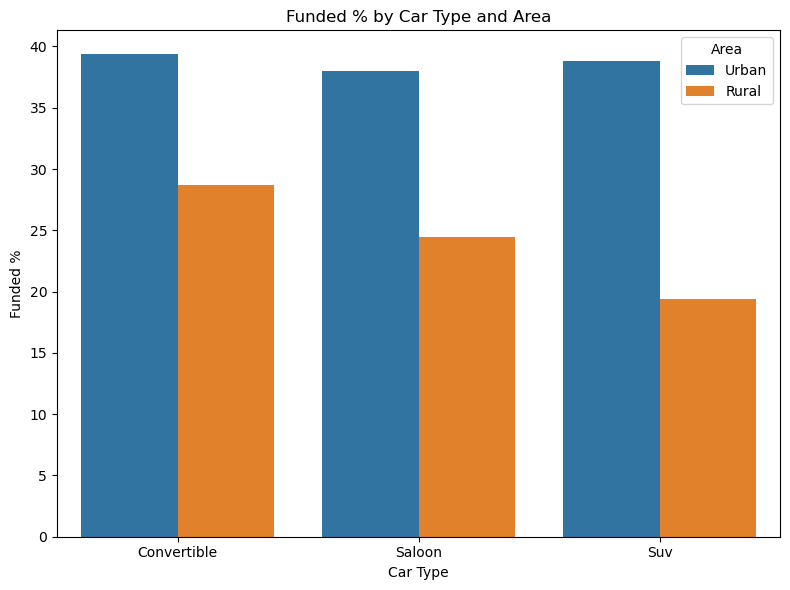

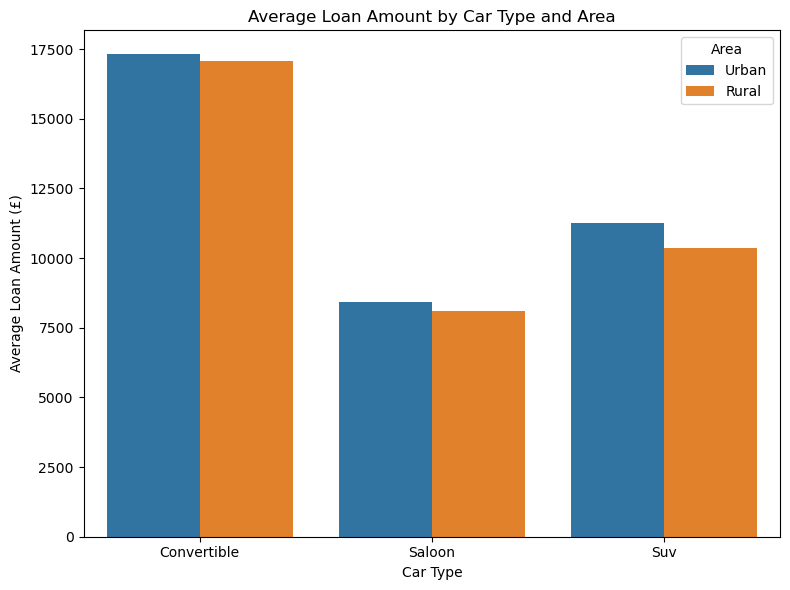

In [27]:
# Funded % grouped bar by Car Type and Area
plt.figure(figsize=(8,6))
sns.barplot(data=car_apr, x="car_type", y="funded_percent", hue="area")

plt.title("Funded % by Car Type and Area")
plt.xlabel("Car Type")
plt.ylabel("Funded %")
plt.legend(title="Area")
plt.tight_layout()
plt.show()

# Average loan amount grouped bar
plt.figure(figsize=(8,6))
sns.barplot(data=car_apr, x="car_type", y="avg_loan_amount", hue="area")

plt.title("Average Loan Amount by Car Type and Area")
plt.xlabel("Car Type")
plt.ylabel("Average Loan Amount (£)")
plt.legend(title="Area")
plt.tight_layout()
plt.show()


### Car type and APR

The query looks only at approved applications and groups results by car_type and funded status. For each group it calculates the minimum, maximum, and average APR, along with the number of applications. This allows comparison of APR patterns between funded and non-funded loans within each car type.

In [28]:
query = """
SELECT
    car_type,
    funded,
    MIN(apr) AS min_apr,
    MAX(apr) AS max_apr,
    ROUND(AVG(apr), 4) AS avg_apr,
    COUNT(*) AS num_applications
FROM applications
WHERE application_outcome = 'Approved'
GROUP BY car_type, funded
ORDER BY car_type, funded;
"""
car_apr = pd.read_sql(query, conn)
car_apr.head()

,car_type,funded,min_apr,max_apr,avg_apr,num_applications
0,Convertible,No,0.05,0.25,0.1158,1086
1,Convertible,Yes,0.05,0.25,0.1197,1031
2,Saloon,No,0.05,0.25,0.1773,1143
3,Saloon,Yes,0.10,0.25,0.1779,984
4,Suv,No,0.05,0.25,0.1497,1172


The results show that APR ranges are similar for funded and unfunded loans across car types. For Convertibles, funded loans have an average APR of 0.120 compared to 0.116 for unfunded, suggesting APR is not a major differentiator for conversion in this category. Saloons show almost identical averages for funded and unfunded loans (0.178 vs 0.177). SUVs, though not fully shown in this preview, have slightly lower average APRs compared to Saloons but still display little difference between funded and non-funded loans. Overall, APR levels appear consistent within each car type, indicating that approval and funding outcomes are driven more by customer or vehicle profiles than by APR variation.

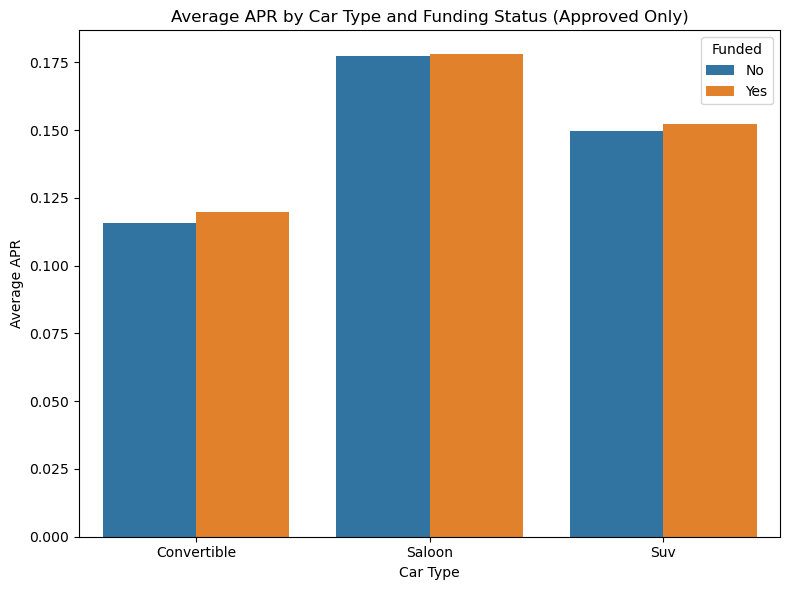

In [29]:
plt.figure(figsize=(8,6))
sns.barplot(data=car_apr, x="car_type", y="avg_apr", hue="funded")

plt.title("Average APR by Car Type and Funding Status (Approved Only)")
plt.xlabel("Car Type")
plt.ylabel("Average APR")
plt.legend(title="Funded")
plt.tight_layout()
plt.show()


### Age vs APR

The query filters for approved applications and groups them by age_band and funded status. It calculates the minimum, maximum, and average APR within each group and counts the number of applications. This allows comparison of APR patterns between funded and unfunded loans across different age bands.

In [30]:
query = """
SELECT
    age_band,
    funded,
    MIN(apr) AS min_apr,
    MAX(apr) AS max_apr,
    ROUND(AVG(apr), 4) AS avg_apr,
    COUNT(*) AS num_applications
FROM applications
WHERE application_outcome = 'Approved'
GROUP BY age_band, funded
ORDER BY age_band, funded;
"""
car_apr = pd.read_sql(query, conn)
car_apr

,age_band,funded,min_apr,max_apr,avg_apr,num_applications
0,18–27,No,0.05,0.25,0.1493,422
1,18–27,Yes,0.05,0.25,0.1499,367
2,28–37,No,0.05,0.25,0.1494,539
3,28–37,Yes,0.05,0.25,0.1481,501
4,38–47,No,0.05,0.25,0.1499,852
5,38–47,Yes,0.05,0.25,0.1480,758
6,48–57,No,0.05,0.25,0.1485,871
7,48–57,Yes,0.05,0.25,0.1465,730
8,58–67,No,0.05,0.25,0.1441,717
9,58–67,Yes,0.05,0.25,0.1552,713


APR values are very similar between funded and unfunded loans in all age groups, with averages clustered around 0.145–0.150. For example, applicants aged 18–27 have an average APR of 0.149 for unfunded and 0.150 for funded loans, showing almost no difference. Middle-aged groups also show consistent averages, while the oldest group 58–67 has a slightly higher average APR for funded loans (0.155) compared to unfunded (0.144). Overall, this suggests that APR does not significantly influence whether an approved applicant ultimately funds, and differences in conversion are more likely driven by demographics or other factors.

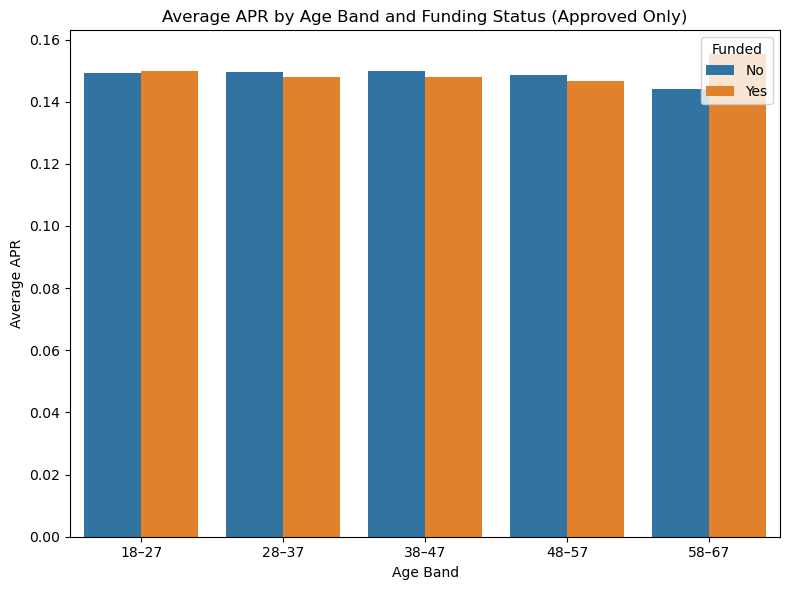

In [31]:
# Bar plot of average APR by age band and funded status
plt.figure(figsize=(8,6))
sns.barplot(data=car_apr, x="age_band", y="avg_apr", hue="funded")

plt.title("Average APR by Age Band and Funding Status (Approved Only)")
plt.xlabel("Age Band")
plt.ylabel("Average APR")
plt.legend(title="Funded")
plt.tight_layout()
plt.show()


### Area vs APR

The query filters approved applications and groups them by area (Rural or Urban) and funding status. For each group it calculates the minimum, maximum, and average APR, along with the number of applications. This allows a comparison of APR distributions between funded and unfunded loans across Urban and Rural segments.

In [32]:
query = """
SELECT
    area,
    funded,
    MIN(apr) AS min_apr,
    MAX(apr) AS max_apr,
    ROUND(AVG(apr), 4) AS avg_apr,
    COUNT(*) AS num_applications
FROM applications
WHERE application_outcome = 'Approved'
GROUP BY area, funded
ORDER BY area, funded;
"""
car_apr = pd.read_sql(query, conn)
car_apr

,area,funded,min_apr,max_apr,avg_apr,num_applications
0,Rural,No,0.05,0.25,0.1498,1798
1,Rural,Yes,0.05,0.25,0.1486,1245
2,Urban,No,0.05,0.25,0.1463,1603
3,Urban,Yes,0.05,0.25,0.1502,1824


Both Rural and Urban applicants show very similar APR ranges, between 0.05 and 0.25. The average APR for Rural funded loans is 0.149 compared to 0.150 for Urban funded, showing no meaningful difference. Likewise, unfunded loans have averages of 0.150 in Rural and 0.146 in Urban, which are nearly identical. The sample sizes are also large (over 1,200–1,800 funded and unfunded each), reinforcing that APR does not materially explain why some approved applicants fund and others do not. This suggests that conversion differences between Rural and Urban customers are likely due to applicant or contextual factors rather than pricing.

### Loan range join with summary table

In [33]:
query = """
SELECT 
    a.age_band,
    a.car_type,
    l.loan_amount_range,
    MIN(apr) min_apr,
    MAX(apr) max_apr,
    AVG(apr) avg_apr
FROM applications a
LEFT JOIN loan_range l ON a.id = l.id
GROUP BY a.age_band,a.car_type,l.loan_amount_range;
"""
loan_range_join = pd.read_sql(query, conn)
loan_range_join.dropna(inplace = True)
loan_range_join

,age_band,car_type,loan_amount_range,min_apr,max_apr,avg_apr
1,18–27,Convertible,10000–14999,0.05,0.25,0.119565
2,18–27,Convertible,15000–19999,0.05,0.25,0.113194
3,18–27,Convertible,20000–24999,0.05,0.25,0.123881
4,18–27,Convertible,25000–29999,0.05,0.25,0.133333
5,18–27,Convertible,5000–9999,0.05,0.25,0.109091
...,...,...,...,...,...,...
74,58–67,Saloon,5000–9999,0.10,0.25,0.178981
76,58–67,Suv,0–4999,0.05,0.25,0.142949
77,58–67,Suv,10000–14999,0.05,0.25,0.164706
78,58–67,Suv,15000–19999,0.05,0.25,0.150373


The query filters only approved applications and groups them by age_band and whether the loan was funded. For each group it calculates the average deposit, the average APR, and the number of applications. This allows comparison of deposit levels and APR patterns between funded and unfunded loans across different age bands.

### Age vs Deposit vs APR

In [34]:
query = """
SELECT 
    age_band,
    funded,
    ROUND(AVG(deposit), 2) AS avg_deposit,
    ROUND(AVG(apr), 4) AS avg_apr,
    COUNT(*) AS num_applications
FROM applications
WHERE application_outcome = 'Approved'
GROUP BY age_band,funded
ORDER BY age_band;
"""
age_dep_apr = pd.read_sql(query, conn)
age_dep_apr


,age_band,funded,avg_deposit,avg_apr,num_applications
0,18–27,No,2618.36,0.1493,422
1,18–27,Yes,2934.51,0.1499,367
2,28–37,No,2762.44,0.1494,539
3,28–37,Yes,2975.29,0.1481,501
4,38–47,No,2550.03,0.1499,852
5,38–47,Yes,2975.78,0.1480,758
6,48–57,No,2594.42,0.1485,871
7,48–57,Yes,2876.20,0.1465,730
8,58–67,No,2788.21,0.1441,717
9,58–67,Yes,2914.33,0.1552,713


Across all age groups, funded applicants consistently put down higher deposits than those who did not fund, while APR differences are minimal. For example, in the 18–27 group, funded loans had an average deposit of about 2,935 compared to 2,618 for non-funded, with APR almost identical at 0.150. This same pattern holds across every age band, including older groups like 38–47 and 48–57. For marketing, the clear takeaway is that applicants who can provide higher deposits are much more likely to complete the journey to funding. Campaigns should therefore target audiences with stronger upfront affordability, since APR alone does not explain differences in funding outcomes.

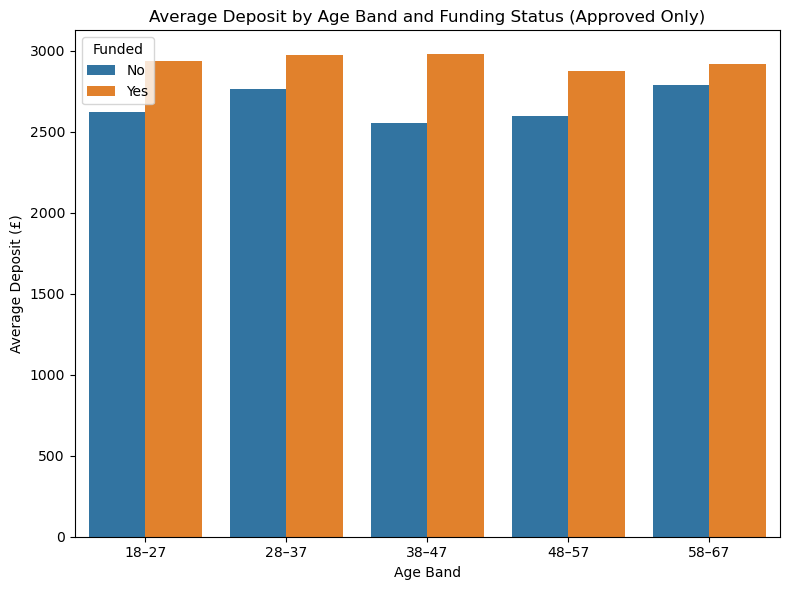

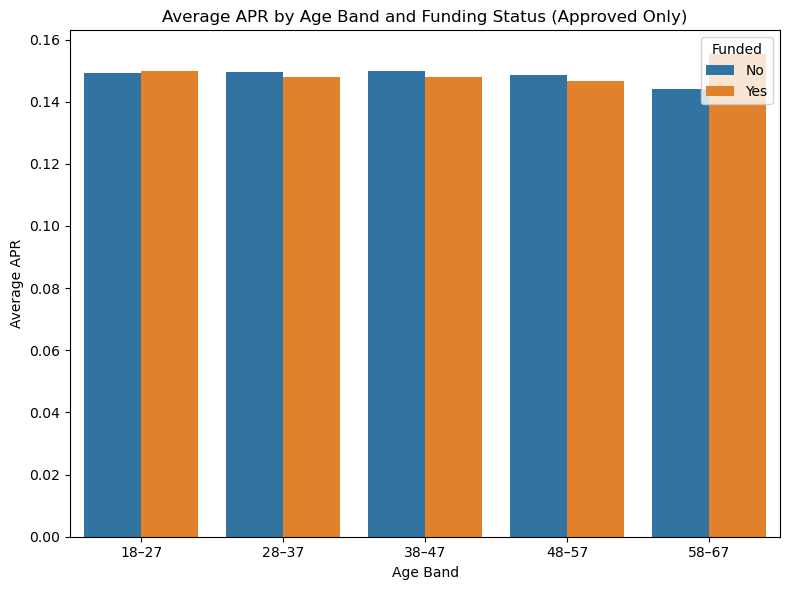

In [35]:
# Grouped bar chart: Average Deposit
plt.figure(figsize=(8,6))
sns.barplot(data=age_dep_apr, x="age_band", y="avg_deposit", hue="funded")
plt.title("Average Deposit by Age Band and Funding Status (Approved Only)")
plt.xlabel("Age Band")
plt.ylabel("Average Deposit (£)")
plt.legend(title="Funded")
plt.tight_layout()
plt.show()

# Grouped bar chart: Average APR
plt.figure(figsize=(8,6))
sns.barplot(data=age_dep_apr, x="age_band", y="avg_apr", hue="funded")
plt.title("Average APR by Age Band and Funding Status (Approved Only)")
plt.xlabel("Age Band")
plt.ylabel("Average APR")
plt.legend(title="Funded")
plt.tight_layout()
plt.show()


### Deposit Ratio analysis

The query groups applications by deposit_ratio_band. For each band it calculates the total number of applications, approvals, and funded loans. It also computes approval and funded rates as percentages of total applications. The results are then ordered by deposit ratio band for easy comparison.

In [36]:
query = """
SELECT 
    deposit_ratio_band,
    COUNT(*) AS total_applications,
    SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END) AS approved,
    SUM(CASE WHEN funded='Yes' THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN application_outcome='Approved' THEN 1.0 ELSE 0 END),4)*100 AS approval_rate,
    ROUND(AVG(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END),4)*100 AS funded_rate
FROM applications
GROUP BY deposit_ratio_band
ORDER BY deposit_ratio_band;
"""
deposit_ratio_summary = pd.read_sql(query, conn)
deposit_ratio_summary

,deposit_ratio_band,total_applications,approved,funded,approval_rate,funded_rate
0,10–20%,2293,1639,791,71.48,34.50
1,20–30%,2076,1413,698,68.06,33.62
2,30–50%,2147,1489,733,69.35,34.14
3,50%+,1143,776,395,67.89,34.56
4,<10%,2341,1153,452,49.25,19.31


Applicants with higher deposits relative to loan amount clearly convert better. Bands from 10–20% through 50%+ deposits all show approval rates near 68–71% and funded rates around 34–35%. In contrast, applicants with deposits under 10% have much weaker funnel performance with only a 49.3% approval rate and a 19.3% funded rate. For marketing, this signals that campaigns should prioritize attracting applicants able to put down at least 10% deposits, since they are nearly twice as likely to result in a funded loan compared to low-deposit applicants.

### LTV analysis

The query groups applications by ltv_band (Loan-to-Value ranges). For each band it calculates total applications, approvals, and funded loans. It also computes approval and funded rates as percentages of total applications. The results show how funnel performance changes as loan-to-value increases.

In [37]:
query = """
SELECT 
    ltv_band,
    COUNT(*) AS total_applications,
    SUM(CASE WHEN application_outcome='Approved' THEN 1 ELSE 0 END) AS approved,
    SUM(CASE WHEN funded='Yes' THEN 1 ELSE 0 END) AS funded,
    ROUND(AVG(CASE WHEN application_outcome='Approved' THEN 1.0 ELSE 0 END),4)*100 AS approval_rate,
    ROUND(AVG(CASE WHEN funded='Yes' THEN 1.0 ELSE 0 END),4)*100 AS funded_rate
FROM applications
GROUP BY ltv_band
ORDER BY ltv_band;
"""
ltv_summary = pd.read_sql(query, conn)
ltv_summary.head()

,ltv_band,total_applications,approved,funded,approval_rate,funded_rate
0,70–80%,2127,1462,731,68.74,34.37
1,80–90%,2299,1639,777,71.29,33.80
2,90–100%,2105,986,376,46.84,17.86
3,≤70%,3469,2383,1185,68.69,34.16


Applicants with LTV up to 90% perform strongly, with approval rates around 69–71% and funded rates about 34%, regardless of whether they are in the ≤70%, 70–80%, or 80–90% bands. However, once LTV rises to 90–100%, performance drops sharply to a 46.8% approval rate and only a 17.9% funded rate. For marketing, this highlights that customers borrowing close to the full value of the car are much less likely to complete the journey. The most effective investment is in applicants with LTV under 90%, where conversion is roughly double compared to high-LTV customers.

### Loan Summary

The query groups applications by loan_amount_range and calculates funnel metrics for each range. It reports total applications, approvals, and funded loans, then computes approval rate, end-to-end conversion rate (funded per applications), and post-approval conversion rate (funded per approvals). This gives a clear view of how performance varies by loan size.

In [38]:
loan_summary = pd.read_sql("""
WITH a AS (
  SELECT
    loan_amount_range AS loan_range,
    LOWER(application_outcome) AS app_outcome,
    LOWER(funded) AS funded_flag
  FROM applications
)
SELECT
  loan_range AS segment,
  COUNT(*) AS applications,
  SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END) AS approvals,
  SUM(CASE WHEN funded_flag='yes' THEN 1 ELSE 0 END) AS funded,
  ROUND(100.0*SUM(CASE WHEN app_outcome='approved' THEN 1.0 ELSE 0 END)/COUNT(*),2) AS approval_rate_pct,
  ROUND(100.0*SUM(CASE WHEN funded_flag='yes' THEN 1.0 ELSE 0 END)/COUNT(*),2) AS funded_percent,
  ROUND(100.0*SUM(CASE WHEN funded_flag='yes' THEN 1.0 ELSE 0 END)/
        NULLIF(SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END),0),2) AS post_approval_conv_pct
FROM a
GROUP BY loan_range
ORDER BY segment, funded_percent DESC, applications DESC;
""", conn)


loan_summary

,segment,applications,approvals,funded,approval_rate_pct,funded_percent,post_approval_conv_pct
0,0–4999,1364,945,422,69.28,30.94,44.66
1,10000–14999,2717,1891,935,69.60,34.41,49.44
2,15000–19999,1906,1341,650,70.36,34.10,48.47
3,20000–24999,879,602,274,68.49,31.17,45.51
4,25000–29999,167,118,63,70.66,37.72,53.39
5,5000–9999,2967,1573,725,53.02,24.44,46.09


Loan sizes between 10,000–19,999 stand out as the strongest ranges, with approval rates around 70% and end-to-end conversion near 34%, supported by solid post-approval conversion of about 48–49%. Smaller loans 0–4,999 perform reasonably with 31% end-to-end, but 5,000–9,999 is noticeably weaker, with only a 53% approval rate and 24% end-to-end conversion. Larger loans 25,000–29,999 perform best overall, achieving a 70.7% approval rate and a 37.7% end-to-end conversion, though volume is low (only 167 applications). For marketing, this suggests that targeting applicants seeking mid-size loans (10,000–20,000) is most effective in balancing volume and efficiency, while high-value loans are attractive but limited in scale.

The query filters for approved applications and groups them by deposit_ratio_band. For each band it calculates the minimum, maximum, and average APR, the number of approved applications, and the post-approval conversion rate (funded per approvals). This shows how deposit size relates to APR levels and funding success after approval.

In [39]:
apr_deposit = pd.read_sql("""
WITH approved AS (
  SELECT
    deposit_ratio_band,
    ROUND(apr,2) AS apr_r2,
    LOWER(funded) AS funded_flag
  FROM applications
  WHERE LOWER(application_outcome)='approved'
)
SELECT
  deposit_ratio_band,
  MIN(apr_r2) AS min_apr,
  MAX(apr_r2) AS max_apr,
  ROUND(AVG(apr_r2),3) AS avg_apr,
  COUNT(*) AS approved_apps,
  ROUND(100.0*AVG(CASE WHEN funded_flag='yes' THEN 1.0 ELSE 0 END),2) AS post_approval_conv_pct
FROM approved
GROUP BY deposit_ratio_band
ORDER BY deposit_ratio_band;
""", conn)
apr_deposit

,deposit_ratio_band,min_apr,max_apr,avg_apr,approved_apps,post_approval_conv_pct
0,10–20%,0.05,0.25,0.147,1639,48.26
1,20–30%,0.05,0.25,0.148,1413,49.40
2,30–50%,0.05,0.25,0.154,1489,49.23
3,50%+,0.05,0.25,0.156,776,50.90
4,<10%,0.05,0.25,0.140,1153,39.20


Applicants with deposits under 10% stand out as the weakest, with an average APR of 0.140 and only a 39.2% post-approval conversion rate. In contrast, applicants with higher deposits (10% or more) have stronger performance, with conversion rates around 48–51% and slightly higher average APRs in the 0.147–0.156 range. This suggests that putting down more deposit not only signals stronger financial health but also leads to better completion rates, even if APR does not drop significantly. For marketing, this means targeting applicants with at least a 10% deposit delivers more reliable funded outcomes, while low-deposit customers are far less efficient to acquire.

### Persona Builder

The code builds a three-way persona key by combining age_band, area, and car_type into a single string. It then aggregates funnel metrics for each persona, including applications, approvals, funded loans, approval rate, end-to-end conversion rate, post-approval conversion rate and calculates the percentage of drop-offs at both the application-to-approval stage and the approval-to-funded stage, filtering out small samples. The results are sorted by end-to-end conversion and stored as a new table segment_personas_3d in the database for reuse.

In [40]:
# 3-way persona key (robust to nulls)
persona_expr = """
age_band || ' | ' ||
area || ' | ' ||
car_type
"""

persona_sql = f"""
WITH base AS (
  SELECT
    {persona_expr} AS persona,
    LOWER(application_outcome) AS app_outcome,
    LOWER(funded) AS funded_flag
  FROM applications
)
SELECT
  persona,
  COUNT(*) AS applications,
  SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END) AS approvals,
  SUM(CASE WHEN funded_flag='yes' THEN 1 ELSE 0 END)     AS funded,
  ROUND(100.0*SUM(CASE WHEN app_outcome='approved' THEN 1.0 ELSE 0 END)/COUNT(*),2) AS approval_rate_pct,
  ROUND(100.0*SUM(CASE WHEN funded_flag='yes' THEN 1.0 ELSE 0 END)/COUNT(*),2) AS funded_percent,      -- funded/apps
  ROUND(100.0*SUM(CASE WHEN funded_flag='yes' THEN 1.0 ELSE 0 END)
        / NULLIF(SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END),0),2) AS post_approval_conv_pct,   -- funded/approvals
  ROUND(100.0*(COUNT(*) - SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END))/COUNT(*),2) AS drop_app_to_approval_pct,
  ROUND(100.0*(SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END) - SUM(CASE WHEN funded_flag='yes' THEN 1 ELSE 0 END))
        / NULLIF(SUM(CASE WHEN app_outcome='approved' THEN 1 ELSE 0 END),0),2) AS drop_approval_to_funded_pct
FROM base
GROUP BY persona
ORDER BY funded_percent DESC, applications DESC;
"""
personas = pd.read_sql(persona_sql, conn)

# Persist for reuse in SQL
personas.to_sql("segment_personas_3d", conn, if_exists="replace", index=False)


30

personas are data-driven customer profiles created by combining key attributes such as age band, area (Urban or Rural), and car type.

Instead of looking at these factors separately, personas capture the intersection of multiple traits.

Each persona shows how a specific type of applicant behaves across the funnel (applications, approvals, funded loans, approval rate, end-to-end conversion, post-approval conversion).

Personas help the marketing team answer who exactly to target. Instead of just knowing that “Urban applicants are better,” they can focus investment on precise, high-value profiles like “Urban 38–47 Saloon applicants” that combine strong approval and conversion rates.

In short, personas are detailed customer segments that bridge technical funnel analysis with actionable marketing strategy.

In [41]:
personas

,persona,applications,approvals,funded,approval_rate_pct,funded_percent,post_approval_conv_pct,drop_app_to_approval_pct,drop_approval_to_funded_pct
0,58–67 | Urban | Saloon,262,250,139,95.42,53.05,55.60,4.58,44.40
1,58–67 | Urban | Suv,269,257,142,95.54,52.79,55.25,4.46,44.75
2,58–67 | Urban | Convertible,274,262,142,95.62,51.82,54.20,4.38,45.80
3,38–47 | Urban | Saloon,362,307,171,84.81,47.24,55.70,15.19,44.30
4,48–57 | Urban | Convertible,307,274,144,89.25,46.91,52.55,10.75,47.45
5,38–47 | Urban | Convertible,315,272,143,86.35,45.40,52.57,13.65,47.43
6,38–47 | Urban | Suv,335,284,148,84.78,44.18,52.11,15.22,47.89
7,48–57 | Urban | Saloon,331,278,145,83.99,43.81,52.16,16.01,47.84
8,48–57 | Urban | Suv,312,270,134,86.54,42.95,49.63,13.46,50.37
9,58–67 | Rural | Convertible,270,224,102,82.96,37.78,45.54,17.04,54.46


The query generated 30 unique personas, each representing a specific age group, location, and car type combination. For each persona, marketing can now see both approval and conversion performance, making it easier to identify which combinations produce the best end-to-end results. This allows marketing to move from broad one-dimensional insights (e.g., “Urban is better than Rural”) to targeted investment strategies such as “Middle-aged Urban SUV applicants,” ensuring budget is focused on the highest-return personas.

For marketing, this highlights two strategies: first, target applicants able to put down stronger deposits since they are much more likely to complete the loan; second, focus budget on golden personas with low early-stage drop-off, while tailoring interventions like messaging or product tweaks for personas that struggle after approval.

The code first calculates global baseline metrics across all applications: total applications, approval rate, and end-to-end conversion rate. It then defines thresholds at the top quartile (75th percentile) for both approval rate and end-to-end conversion across personas. Personas with at least 50 applications and performance above both thresholds are flagged as “golden” segments. These are sorted by end-to-end conversion, approval rate, and volume, and stored as a new table golden_personas for reuse.

In [42]:
# Global baselines (for context)
baseline = pd.read_sql("""
SELECT
  COUNT(*) apps,
  ROUND(100.0*AVG(CASE WHEN LOWER(application_outcome)='approved' THEN 1.0 ELSE 0 END),2) AS approval_rate_pct,
  ROUND(100.0*AVG(CASE WHEN LOWER(funded)='yes' THEN 1.0 ELSE 0 END),2) AS funded_percent
FROM applications;
""", conn).iloc[0]

appr_q75 = personas["approval_rate_pct"].quantile(0.75)
fund_q75  = personas["funded_percent"].quantile(0.75)

condition1 = personas['applications'] >= 50
condition2 = personas['approval_rate_pct'] >= appr_q75
condition3 = personas['funded_percent'] >= fund_q75

golden = (
    personas[condition1 & condition2 & condition3]
    .sort_values(
        by=["funded_percent", "approval_rate_pct", "applications"], 
        ascending=[False, False, False]
    )
)

golden.to_sql("golden_personas", conn, if_exists="replace", index=False)


6

The query identified 6 golden personas that outperform the overall baseline. These personas combine strong approval rates and high end-to-end conversion while maintaining sufficient volume, making them the most valuable customer profiles. For marketing, these golden personas represent the clearest opportunities to maximize funded loans efficiently. Investing more in attracting applicants that match these 6 profiles will deliver significantly better ROI compared to the average applicant base.

**Note**: Personas with fewer than 50 applications were excluded to prevent small-sample noise. This ensures golden segments are both statistically reliable and commercially scalable.

**Why the 50-application threshold was used**

When ranking personas, some combinations of age × car type × area are very small. A persona with only a handful of applications might show artificially high or low conversion rates due to randomness rather than true performance.
To avoid chasing “false winners,” we applied a minimum sample size of 50 applications. This acts as a small-sample guard:
- Technically, it reduces noise and ensures rates are statistically meaningful.
- From a business perspective, it avoids recommending segments that are too small to matter for marketing investment.

In practice, this threshold still left enough personas to compare while filtering out those with negligible scale.

The function delta_funded_for_shift estimates the incremental funded loans if a certain number of applications (n_apps) are shifted from one segment to another. It looks up the end-to-end conversion rates (funded per applications) for the from_seg and to_seg, then multiplies the difference in conversion by the number of applications moved. The example tries to simulate moving 1,000 applications from Saloons to SUVs using the car_view summary.

In [43]:
def delta_funded_for_shift(segments_df: pd.DataFrame, from_seg: str, to_seg: str, n_apps: int) -> float:
    s_from = segments_df.loc[segments_df["car_type" if "car_type" in segments_df.columns else "persona"]==from_seg]
    s_to   = segments_df.loc[segments_df["car_type" if "car_type" in segments_df.columns else "persona"]==to_seg]
    if s_from.empty or s_to.empty: return 0.0
    conv_from = float(s_from.iloc[0]["funded_percent"])/100.0
    conv_to   = float(s_to.iloc[0]["funded_percent"])/100.0
    return n_apps * (conv_to - conv_from)

# Example using car_view:
incremental = delta_funded_for_shift(car_type_dist, "Saloon", "Convertible", 1000)
incremental

26.199999999999946

In the example, 1,000 applications are hypothetically shifted from Saloons to Convertibles.

- Saloons have a funded-per-application rate of about 31.37%.

- Convertibles have a higher funded rate of about 33.99%.

- The difference is 2.62 percentage points.

- Multiplying this gap by 1,000 applications yields an incremental 26 funded loans.

For marketing, this demonstrates the business impact of reallocation: moving spend away from Saloons toward Convertibles would be expected to produce 26 more funded loans for every 1,000 applicants redirected. This kind of quantified scenario helps justify budget shifts with a clear ROI estimate.

The function reallocate_bottom_to_top simulates the effect of reallocating applications from the weakest to the strongest segments. It sorts segments by end-to-end conversion rate, takes the bottom decile and the top decile, then pairs them up. It moves an equal share of applicants from each low-performing segment to each high-performing one and calculates the incremental funded loans gained. In the example, 1,000 applicants are redistributed across personas, producing both a detailed plan and a total expected gain.

In [44]:
def reallocate_bottom_to_top(segments_df: pd.DataFrame, total_to_move: int, id_col="segment"):
    df = segments_df.copy()
    df = df.sort_values("funded_percent")
    k = max(1, round(0.1*len(df))) # <---- change value from 0.1 to any other value to get top 3 or 4 or more segments. 
    # eg: 0.17*30 = top 5 segments
    bottom = df.head(k)[[id_col,"funded_percent"]].rename(columns={id_col:"from_seg"})
    top    = df.tail(k)[[id_col,"funded_percent"]].rename(columns={id_col:"to_seg"})

    per_pair = total_to_move // k
    moves = []
    for i in range(k):
        moves.append({
            "from_seg": bottom.iloc[i]["from_seg"],
            "from_seg_funded_percent": bottom.iloc[i]["funded_percent"],
            "to_seg":   top.iloc[i]["to_seg"],
            "to_seg_funded_percent": top.iloc[i]["funded_percent"],
            "n_move":   per_pair,
            "delta_funded":
                per_pair*((top.iloc[i]["funded_percent"] - bottom.iloc[i]["funded_percent"])/100.0)
        })
    out = pd.DataFrame(moves)
    return out, out["delta_funded"].sum()

# Example: reallocate 1000 applicants across personas:
plan, total_gain = reallocate_bottom_to_top( personas.rename(columns={"persona":"segment"}), total_to_move=1000, id_col="segment")

In [45]:
plan

## delta_funded is the incremental number of funded loans gained (or lost) when a specific number of applications are shifted from one segment to another.

,from_seg,from_seg_funded_percent,to_seg,to_seg_funded_percent,n_move,delta_funded
0,18–27 | Rural | Suv,4.74,58–67 | Urban | Convertible,51.82,333,156.7764
1,18–27 | Rural | Saloon,14.11,58–67 | Urban | Suv,52.79,333,128.8044
2,18–27 | Rural | Convertible,16.44,58–67 | Urban | Saloon,53.05,333,121.9113


total_gain is the sum of all incremental funded loans achieved by reallocating applicants from the weakest to the strongest personas.

For example, if you reallocate 1,000 applicants:

Some may move from “18–27 Rural SUV” (funded_percent ~5%) to “58–67 Urban Convertible” (funded_percent ~52%).

The difference in conversion creates a big lift in funded loans.

Adding up all such reallocation gains across the bottom vs top personas gives you the total_gain.

So, in business terms:
total_gain represents the projected number of extra funded loans you would generate by reallocating total_to_move applicants from low-performing segments to high-performing segments.

In [46]:
total_gain

407.49209999999994

The plan shows that reallocating 333 applicants each from the lowest-performing personas (18–27 Rural SUV, Saloon, and Convertible) to the top-performing personas (58–67 Urban Convertible, SUV, and Saloon) would generate significant gains. Specifically, the reallocation delivers an incremental ≈407 funded loans compared to leaving applicants in the original low-quality segments. For marketing, this demonstrates the direct business case: shifting acquisition budget away from young rural applicants toward older urban applicants could nearly double conversion efficiency, turning the same volume of leads into hundreds more funded loans.

In [47]:
# Close connection of the SQLite database when done
conn.close()


# Recommendation

# Final Recommendation for Marketing

## Baseline Funnel
- Out of **10,000 applications**, **6,470 were approved** (approval rate **64.7%**).  
- **3,069 were funded**, giving an overall **end-to-end funded rate of 30.7%**.  
- This baseline is the benchmark for all segment comparisons.

---

## Key Segment Findings

### Age
- Younger applicants (18–27) perform poorly: only **30.1% approval** and **14.0% funded per application**.  
- Older groups (38–67) consistently outperform with **approval 82–90%** and **funded 38–45%**.  
- **Recommendation:** Prioritise **38–67 age bands**; reduce spend on 18–27.

### Area
- **Urban:** 4,710 applications, **72.8% approval**, **38.7% funded**.  
- **Rural:** 5,290 applications, **57.5% approval**, **23.5% funded**.  
- **Recommendation:** Direct spend toward **Urban audiences**, where ROI is higher.

### Car Type
- **Convertibles:** **69.8% approval**, **34.0% funded**.  
- **Saloons:** **67.8% approval**, **31.4% funded**.  
- **SUVs:** largest volume (3,830 apps) but weakest quality (**58.1% approval**, **27.5% funded**).  
- **Recommendation:** Focus budget on **Convertibles and Saloons**; deprioritise SUVs despite volume.

### Deposit Ratio & LTV
- Deposits <10% → **49% approval, 19% funded**.  
- Deposits ≥10% → **~69–71% approval, 34–35% funded**.  
- LTV ≤90% → **~69–71% approval, 34% funded**.  
- LTV 90–100% → only **47% approval, 18% funded**.  
- **Recommendation:** Target applicants with **≥10% deposit and LTV under 90%**.

### Personas (Age × Car × Area)
- Identified **6 golden personas** with both approval and end-to-end conversion rates in the **top quartile**, each with ≥50 applications.  
- These are typically **Urban, 38–67, Convertibles or Saloons**.  
- **Recommendation:** Treat these golden personas as priority targets for acquisition campaigns.

---

## Quantified Business Case
- Simulation shows reallocating **1,000 applicants** from bottom-decile personas (e.g., **18–27 Rural SUVs/Saloon/Convertible**) 
  to top-decile personas (e.g., **58–67 Urban Convertible/SUV/Saloon**) yields **~+407 incremental funded loans**.  
- This represents a **40% uplift in funded loans** compared to leaving allocation unchanged.

---

## Conclusion
The analysis is clear:
- **Who to target:** Urban applicants aged **38–67**, particularly those interested in **Convertibles or Saloons**, with **≥10% deposits and LTV <90%**.  
- **Who to deprioritise:** Young (18–27), Rural, low-deposit, and high-LTV applicants, as they underperform at every funnel stage.  
- **Expected impact:** By reallocating acquisition spend toward golden personas, Marketing can increase funded loans by **~40% with no increase in applications**, maximising ROI on spend.
